# Total Flight Forecast & Cancellation

# Overview

Covid-19 pandemic restriction had huge effect on aviation sector. Many flights are cancelled due to limiting its spread by air transport during 2020. According to McKinsey air traffic won’t return to 2019 levels before 2024. Because of this it is important to predict the air traffic to avoid huge cancellations. In this project air traffic in US for 2021 will be forecasted.

Dataset is set provided by the American Bureau of Transportation Statistics. Macroecenomic data are scrapped by FredApi

The aim of this project to capture Covid-19 pandemic period pattern and forecast short-term total flights not to loose the opportunities.


# Import Libraries

In [1]:
#!pip install basemap
#!pip install pmdarima
#!pip install fredap

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [3]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import dates
from matplotlib.ticker import AutoMinorLocator, MaxNLocator
from mpl_toolkits.basemap import Basemap
import seaborn as sns
import datetime as dt
from scipy.stats.stats import pearsonr 
import optuna
import math
import os

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.tools import diff
from pmdarima import auto_arima


from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, make_scorer

from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge

from pandas.plotting import lag_plot

pd.set_option("display.max_columns",100)
plt.rcParams["figure.figsize"]=(12,8)
import warnings
warnings.filterwarnings("ignore")

In [4]:
def seed_everything(seed=42):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)



## Load Data

In [5]:
airport = pd.read_csv("/home/guler/Desktop/ZeroG/airports.csv").drop(["AIRPORT", "COUNTRY"], axis=1).rename(columns=str.lower)
macrodata = pd.read_csv("/home/guler/Desktop/ZeroG/macro_stat.csv", index_col=[0], parse_dates=True)
df = pd.read_csv("/home/guler/Desktop/ZeroG/airline_delay_causes.csv", ).drop("Unnamed: 21", axis=1).rename(columns=str.strip)
fear_index = pd.read_csv("/home/guler/Desktop/ZeroG/vix_2003.csv", )

In [6]:
df['year_month'] = pd.to_datetime({"year":df.year, "month":df.month, "day":1})

fear_index['year_month'] = pd.to_datetime({"year":fear_index.year, "month":fear_index.month, "day":1})
fear_index.drop(["year", "month"], axis=1, inplace=True)

macrodata.index.rename("year_month", inplace=True)
df = df.merge(airport, how="left", left_on="airport", right_on="iata" ).drop("iata", axis=1)

df.set_index("year_month", drop=True, inplace=True)

df.head(2)

,year,month,carrier,carrier_name,airport,airport_name,arr_flights,arr_del15,carrier_ct,weather_ct,nas_ct,security_ct,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,city,state,latitude,longitude
year_month,,,,,,,,,,,,,,,,,,,,,,,,,
2009-11-01,2009,11,AS,Alaska Airlines Inc.,DCA,"Washington, DC: Ronald Reagan Washington National",88.0,11.0,1.99,0.0,9.01,0.0,0.0,0.0,0.0,266.0,65.0,0.0,201.0,0.0,0.0,Arlington,VA,38.852083,-77.037722
2009-11-01,2009,11,AS,Alaska Airlines Inc.,DEN,"Denver, CO: Denver International",123.0,5.0,3.47,0.0,1.53,0.0,0.0,0.0,0.0,81.0,57.0,0.0,24.0,0.0,0.0,Denver,CO,39.858408,-104.667002


In [7]:
print(f"Colums of data \n\n{df.columns}")

Colums of data 

Index(['year', 'month', 'carrier', 'carrier_name', 'airport', 'airport_name',
       'arr_flights', 'arr_del15', 'carrier_ct', 'weather_ct', 'nas_ct',
       'security_ct', 'late_aircraft_ct', 'arr_cancelled', 'arr_diverted',
       'arr_delay', 'carrier_delay', 'weather_delay', 'nas_delay',
       'security_delay', 'late_aircraft_delay', 'city', 'state', 'latitude',
       'longitude'],
      dtype='object')


In [8]:
print(f"Number of Duplicated Observations: {df.duplicated().sum()}")

Number of Duplicated Observations: 0


In [9]:
print(f"Number of Observations: {df.shape[0]:,}")

Number of Observations: 73,282


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 73282 entries, 2009-11-01 to 2018-11-01
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   year                 73282 non-null  int64  
 1   month                73282 non-null  int64  
 2   carrier              73282 non-null  object 
 3   carrier_name         73282 non-null  object 
 4   airport              73282 non-null  object 
 5   airport_name         73282 non-null  object 
 6   arr_flights          73240 non-null  float64
 7   arr_del15            73211 non-null  float64
 8   carrier_ct           73240 non-null  float64
 9   weather_ct           73240 non-null  float64
 10  nas_ct               73240 non-null  float64
 11  security_ct          73240 non-null  float64
 12  late_aircraft_ct     73240 non-null  float64
 13  arr_cancelled        73240 non-null  float64
 14  arr_diverted         73240 non-null  float64
 15  arr_delay          

# Data Cleaning & Imputing Missing Values

In [11]:
print(f"Features having Missing Values")
df.isnull().sum()[df.isnull().sum() > 0]

Features having Missing Values


arr_flights            42
arr_del15              71
carrier_ct             42
weather_ct             42
nas_ct                 42
security_ct            42
late_aircraft_ct       42
arr_cancelled          42
arr_diverted           42
arr_delay              42
carrier_delay          42
weather_delay          42
nas_delay              42
security_delay         42
late_aircraft_delay    42
dtype: int64

In [12]:
# all delay related fetaures are missing

df = df.dropna(subset = ["arr_flights", "carrier_ct", "weather_ct", "nas_ct", "late_aircraft_ct"])

42 obs. of the following features are null. So it not possible to impute these values. These 42 observation will be deleted.

In [13]:
print(f"After Deleting 42 observation we still have")
df.isnull().sum()[df.isnull().sum() > 0]

After Deleting 42 observation we still have


arr_del15    29
dtype: int64

In [14]:
df.loc[df.arr_del15.isnull()].head(5)

,year,month,carrier,carrier_name,airport,airport_name,arr_flights,arr_del15,carrier_ct,weather_ct,nas_ct,security_ct,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,city,state,latitude,longitude
year_month,,,,,,,,,,,,,,,,,,,,,,,,,
2019-03-01,2019,3,EV,ExpressJet Airlines Inc.,PHL,"Philadelphia, PA: Philadelphia International",1.0,NaN,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Philadelphia,PA,39.871953,-75.241141
2020-04-01,2020,4,9E,Endeavor Air Inc.,CLT,"Charlotte, NC: Charlotte Douglas International",20.0,NaN,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Charlotte,NC,35.214011,-80.943126
2020-04-01,2020,4,9E,Endeavor Air Inc.,EWR,"Newark, NJ: Newark Liberty International",7.0,NaN,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Newark,NJ,40.692497,-74.168661
2020-04-01,2020,4,9E,Endeavor Air Inc.,FLL,"Fort Lauderdale, FL: Fort Lauderdale-Hollywood...",7.0,NaN,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Ft. Lauderdale,FL,26.072583,-80.152750
2020-04-01,2020,4,9E,Endeavor Air Inc.,IAD,"Washington, DC: Washington Dulles International",13.0,NaN,0.0,0.0,0.0,0.0,0.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Chantilly,VA,38.944532,-77.455810


In [15]:
delay_cols = [col for col in df.columns if str(col).endswith("_delay")]
ct_cols = [col for col in df.columns if str(col).endswith("_ct")]
num_cols = [col for col in df.columns if df[col].dtype !="object"]
cat_cols = [col for col in df.columns if df[col].dtype =="object"]
delay_ct_cols = ct_cols + delay_cols

missing 29 value of feature arr_del15 other delay related values are 0. So these missing values are ZERO.

In [16]:
df.arr_del15 = np.where((df[delay_cols].sum(axis=1) == 0) & (df.arr_del15.isnull()), 0,df.arr_del15)

In [17]:
print(f"Number of total observation (after deleting and correcting values): {df.shape[0]:,}")

Number of total observation (after deleting and correcting values): 73,240


In [18]:
df.airport_name = df.airport_name.str.split(":",expand=True)[1].str.strip()

## Correction of Carrier code and Carrier Name

In [19]:
companies = []
list1 = list(df.carrier.unique())
list2 = list(df.carrier.loc[df.index == "2020-12"].unique())

for i in range(len(df.carrier.unique())):
    if list1[i] not in list2:
        companies.append(list1[i])
        
print(f"Carriers don't have any flight in the last period of data 2020-12 \n\n{companies}")

Carriers don't have any flight in the last period of data 2020-12 

['CO', 'EV', 'FL', 'NW', 'US', 'XE', 'RU', 'TZ', 'DH', 'HP', 'VX', 'AQ']


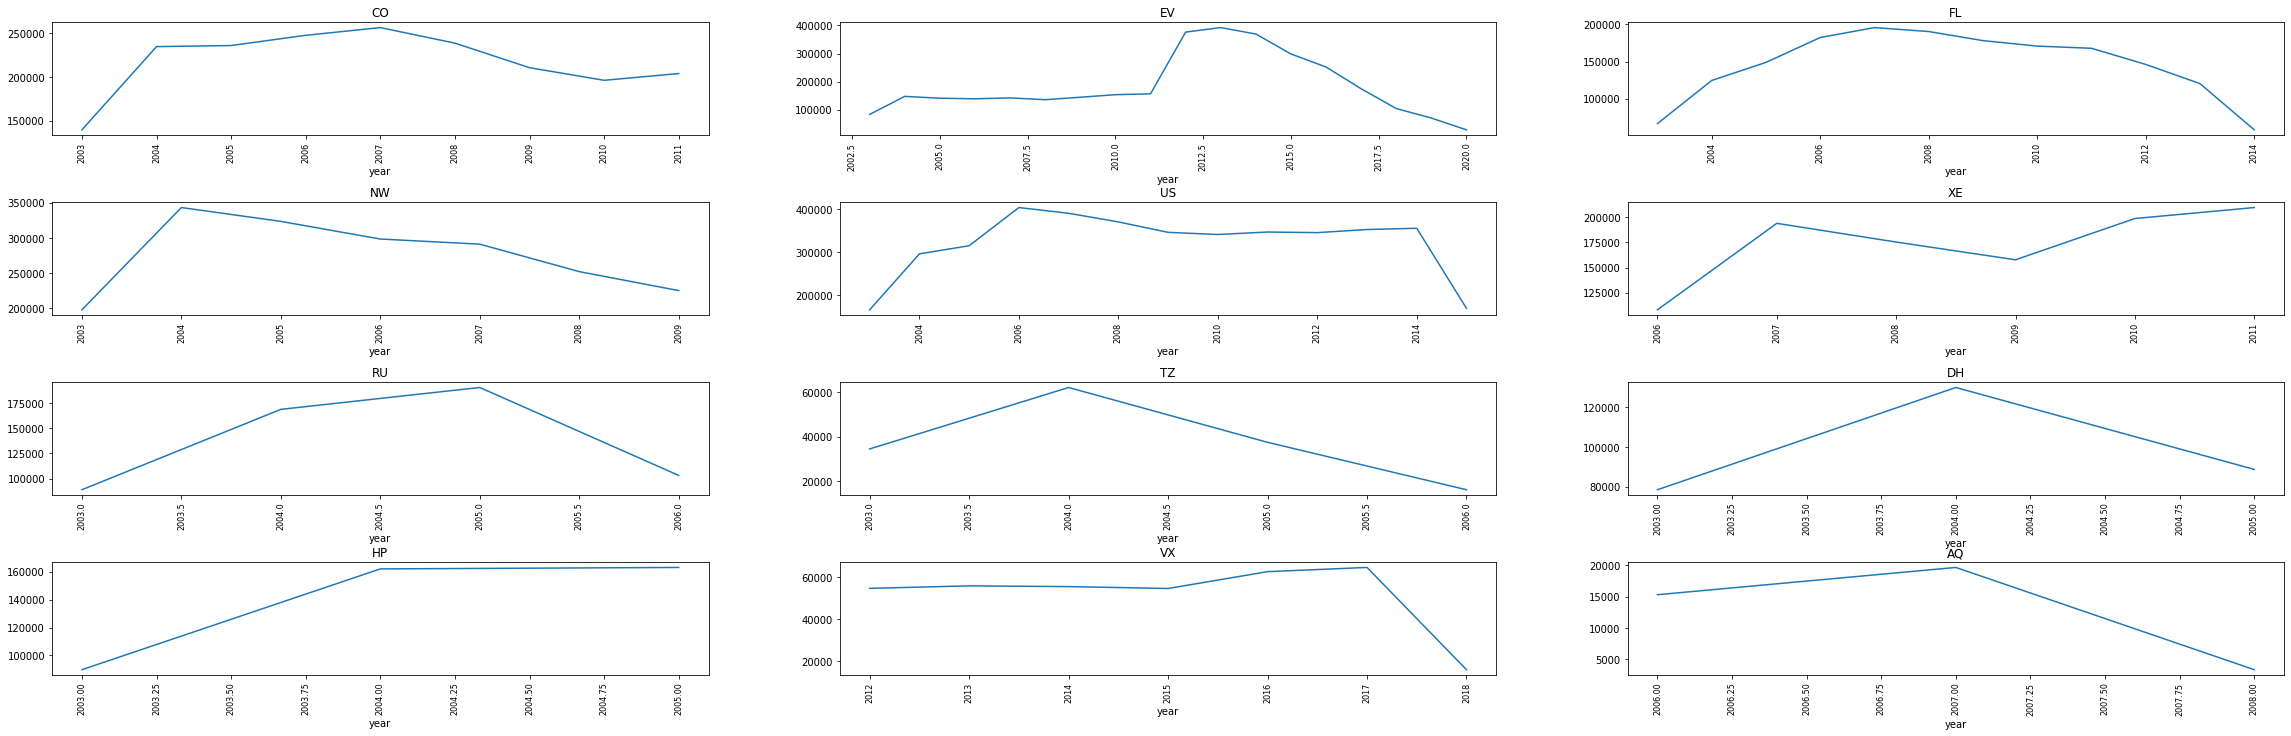

In [20]:
plt.figure(figsize=(40,12))

for idx, col in enumerate(companies):
    plt.subplot(4,3, idx+1)
    df.loc[(df.carrier == col) ].groupby("year").sum()["arr_flights"].plot()
    plt.title(f"{col}")
    plt.xticks(fontsize=8, rotation=90)
    plt.subplots_adjust(  hspace=0.6)

In [21]:
df.groupby(["carrier", "carrier_name"]).sum()["year"]

carrier  carrier_name                
9E       Endeavor Air Inc.                1428835
         Pinnacle Airlines Inc.           1653689
AA       American Airlines Inc.          12389784
AQ       Aloha Airlines Inc.               138462
AS       Alaska Airlines Inc.             8674966
B6       JetBlue Airways                  8707104
CO       Continental Air Lines Inc.       5856775
DH       Atlantic Coast Airlines           354631
         Independence Air                  372901
DL       Delta Air Lines Inc.            12651744
EV       Atlantic Southeast Airlines      2908385
         ExpressJet Airlines Inc.         3054391
         ExpressJet Airlines LLC           300887
F9       Frontier Airlines Inc.           8579074
FL       AirTran Airways Corporation      5626133
G4       Allegiant Air                     516871
HA       Hawaiian Airlines Inc.           3492991
HP       America West Airlines Inc.       1617359
MQ       American Eagle Airlines Inc.     4775713
         Env

**['CO', 'EV', 'FL', 'NW', 'US', 'XE', 'RU', 'TZ', 'DH', 'HP', 'VX', 'AQ'] airlines didn't have data for last PERIOD. Needed to be corrected******

* AQ - Aloha Airlines Inc. ceased on 31 March 2008
* CO - Continental and UA - United Airlines merged 
* EV - (Atlantic Southeast Airlines,ExpressJet Airlines Inc., ExpressJet Airlines LLC ) & RU - (ExpressJet Airlines Inc.) & XE - (ExpressJet Airlines Inc.) all same. starten on 10-2021 as AHA      
* FL - AirTran Airways and parent AirTran Holdings were acquired by WN - Southwest Airlines on May 2, 2011
* NW - Northwest Airlines ==> DL - Delta Airlines
* US - US Airways ==> AA - American Airlines
* TZ - ATA Airlines ==> WN - Southwest Airlines 
* DH - Atlantic Coast Airlines ==> DH - Independence Air ==> NW -  Northwest Airlines ==> DL - Delta Air Lines Inc. 
* HP - America West Airlines Inc. rebranded as US - US Airways Inc.  ==> AA - American Airlines
* VX - Virgin America  ==> AS - Alaska Air Group

In [22]:
df.carrier.replace("CO", "UA", inplace=True)
df.carrier.replace("RU", "EV", inplace=True)
df.carrier.replace("XE", "EV", inplace=True)
df.carrier.replace("FL", "WN", inplace=True)
df.carrier.replace("NW", "DL", inplace=True)
df.carrier.replace("US", "AA", inplace=True)
df.carrier.replace("TZ", "WN", inplace=True)
df.carrier.replace("DH", "WN", inplace=True)
df.carrier.replace("DH", "DL", inplace=True)
df.carrier.replace("HP", "AA", inplace=True)
df.carrier.replace("US", "AA", inplace=True)
df.carrier.replace("VX", "AS", inplace=True)

df.loc[(df.carrier=="OH") & (df.carrier_name=="Comair Inc."), "carrier"] = "DL"

In [23]:
df.carrier.unique()

array(['AS', 'B6', 'UA', 'DL', 'EV', 'F9', 'WN', 'HA', 'MQ', 'OO', 'AA',
       'YV', '9E', 'NK', 'OH', 'YX', 'G4', 'AQ'], dtype=object)

## Update Carrier Name

In [24]:
df.groupby(["carrier", "carrier_name"]).sum()["year"]

carrier  carrier_name                
9E       Endeavor Air Inc.                1428835
         Pinnacle Airlines Inc.           1653689
AA       America West Airlines Inc.       1617359
         American Airlines Inc.          12389784
         US Airways Inc.                  8098513
AQ       Aloha Airlines Inc.               138462
AS       Alaska Airlines Inc.             8674966
         Virgin America                   2401598
B6       JetBlue Airways                  8707104
DL       Comair Inc.                      3349483
         Delta Air Lines Inc.            12651744
         Northwest Airlines Inc.          4748643
EV       Atlantic Southeast Airlines      2908385
         ExpressJet Airlines Inc.         7459937
         ExpressJet Airlines LLC           300887
F9       Frontier Airlines Inc.           8579074
G4       Allegiant Air                     516871
HA       Hawaiian Airlines Inc.           3492991
MQ       American Eagle Airlines Inc.     4775713
         Env

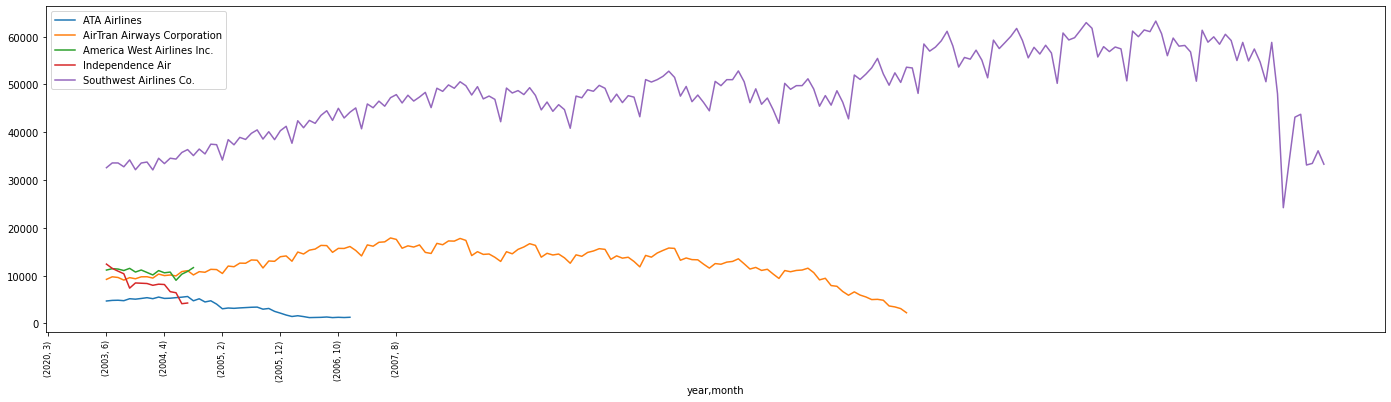

In [25]:
plt.figure(figsize=(24,6))

df.loc[(df.carrier == "WN") & (df.carrier_name == "ATA Airlines d/b/a ATA")].groupby(["year", "month"]).sum()["arr_flights"].plot(label="ATA Airlines")
df.loc[(df.carrier == "WN") & (df.carrier_name == "AirTran Airways Corporation")].groupby(["year", "month"]).sum()["arr_flights"].plot(label="AirTran Airways Corporation")
df.loc[(df.carrier == "WN") & (df.carrier_name == "Atlantic Coast Airlines")].groupby(["year", "month"]).sum()["arr_flights"].plot(label="America West Airlines Inc.")
df.loc[(df.carrier == "WN") & (df.carrier_name == "Independence Air")].groupby(["year", "month"]).sum()["arr_flights"].plot(label="Independence Air")
df.loc[(df.carrier == "WN") & (df.carrier_name == "Southwest Airlines Co.")].groupby(["year", "month"]).sum()["arr_flights"].plot(label="Southwest Airlines Co.")

# df.loc[(df.carrier == "AS") & (df.carrier_name == "Alaska Airlines Inc.")].groupby(["year", "month"]).sum()["arr_flights"].plot(label="Alaska Airlines Inc.")
# df.loc[(df.carrier == "AS") & (df.carrier_name == "Virgin America")].groupby(["year", "month"]).sum()["arr_flights"].plot(label="Virgin America ")

# df.loc[(df.carrier == "DL") & (df.carrier_name == "Delta Air Lines Inc.")].groupby(["year", "month"]).sum()["arr_flights"].plot(label="Delta Air Lines Inc.")
# df.loc[(df.carrier == "DL") & (df.carrier_name == "Northwest Airlines Inc.")].groupby(["year", "month"]).sum()["arr_flights"].plot(label="Northwest Airlines Inc. ")
# df.loc[(df.carrier == "DL") & (df.carrier_name == "Comair Inc.")].groupby(["year", "month"]).sum()["arr_flights"].plot(label="Comair Inc.")

# df.loc[(df.carrier == "OH") & (df.carrier_name == "PSA Airlines Inc.")].groupby(["year", "month"]).sum()["arr_flights"].plot(label="PSA Airlines Inc.")
# df.loc[(df.carrier == "AA")].groupby(["year", "month"]).sum()["arr_flights"].plot(label="Delta Air Lines Inc.")

# df.loc[(df.carrier == "EV") & (df.carrier_name == "Atlantic Southeast Airlines")].groupby(["year", "month"]).sum()["arr_flights"].plot(label="Atlantic Southeast Airlines ")
# df.loc[(df.carrier == "EV") & (df.carrier_name == "ExpressJet Airlines Inc.")].groupby(["year", "month"]).sum()["arr_flights"].plot(label="ExpressJet Airlines Inc.")
# df.loc[(df.carrier == "EV") & (df.carrier_name == "ExpressJet Airlines LLC")].groupby(["year", "month"]).sum()["arr_flights"].plot(label="ExpressJet Airlines LLC")


# df.loc[(df.carrier == "AA") & (df.carrier_name == "America West Airlines Inc.")].groupby(["year", "month"]).sum()["arr_flights"].plot(label="America West Airlines Inc.")
# df.loc[(df.carrier == "AA") & (df.carrier_name == "American Airlines Inc.")].groupby(["year", "month"]).sum()["arr_flights"].plot(label="American Airlines Inc.")
# df.loc[(df.carrier == "AA") & (df.carrier_name == "US Airways Inc.")].groupby(["year", "month"]).sum()["arr_flights"].plot(label="US Airways Inc.")

# df.loc[(df.carrier == "9E") & (df.carrier_name == "Pinnacle Airlines Inc.")].groupby(["year", "month"]).sum()["arr_flights"].plot( label="Pinnacle Airlines Inc.")
# df.loc[(df.carrier == "9E") & (df.carrier_name == "Endeavor Air Inc.")].groupby(["year", "month"]).sum()["arr_flights"].plot( label="Endeavor Air Inc.",)

# df.loc[(df.carrier == "MQ") & (df.carrier_name == "American Eagle Airlines Inc.")].groupby(["year", "month"]).sum()["arr_flights"].plot(label="American Eagle Airlines Inc.")
# df.loc[(df.carrier == "MQ") & (df.carrier_name == "Envoy Air")].groupby(["year", "month"]).sum()["arr_flights"].plot(label="Envoy Air")

plt.legend()
plt.xticks(fontsize=8, rotation=90);

* Pinnacle Airlines Inc. ==> Endeavor Air Inc.
* America West Airlines Inc. ==> American Airlines Inc.
* US Airways Inc.  ==> AA - American Airlines
* Virgin America ==> Alaska Airlines Inc.
* Northwest Airlines Inc. ==> Delta Air Lines Inc.
* Comair Inc. ==> Delta Air Lines Inc.
* Atlantic Southeast Airlines ==> ExpressJet Airlines Inc.
* ExpressJet Airlines LLC ==> ExpressJet Airlines Inc.
* American Eagle Airlines Inc. ==> Envoy Air
* Continental Air Lines Inc. ==> United Air Lines Inc.
* ATA Airlines d/b/a ATA ==> Southwest Airlines Co.
* AirTran Airways Corporation ==> Southwest Airlines Co.
* Atlantic Coast Airlines ==> Southwest Airlines Co.
* Independence Air ==> Southwest Airlines Co.   


In [26]:
df.carrier_name.replace("Pinnacle Airlines Inc.", "Endeavor Air Inc.", inplace=True)
df.carrier_name.replace("America West Airlines Inc.", "American Airlines Inc.", inplace=True)
df.carrier_name.replace("US Airways Inc.", "American Airlines Inc.", inplace=True)
df.carrier_name.replace("Virgin America", "Alaska Airlines Inc.", inplace=True)
df.carrier_name.replace("Northwest Airlines Inc.", "Delta Air Lines Inc.", inplace=True)
df.carrier_name.replace("Comair Inc.", "Delta Air Lines Inc.", inplace=True)
df.carrier_name.replace("Atlantic Southeast Airlines", "ExpressJet Airlines Inc.", inplace=True)
df.carrier_name.replace("ExpressJet Airlines LLC", "ExpressJet Airlines Inc.", inplace=True)
df.carrier_name.replace("American Eagle Airlines Inc.", "Envoy Air", inplace=True)
df.carrier_name.replace("Continental Air Lines Inc.", "United Air Lines Inc.", inplace=True)
df.carrier_name.replace("ATA Airlines d/b/a ATA", "Southwest Airlines Co.", inplace=True)
df.carrier_name.replace("AirTran Airways Corporation", "Southwest Airlines Co.", inplace=True)
df.carrier_name.replace("Atlantic Coast Airlines", "Southwest Airlines Co.", inplace=True)
df.carrier_name.replace("Independence Air", "Southwest Airlines Co.", inplace=True)

In [27]:
df.groupby(["carrier", "carrier_name"]).sum()["year"]

carrier  carrier_name            
9E       Endeavor Air Inc.            3082524
AA       American Airlines Inc.      22105656
AQ       Aloha Airlines Inc.           138462
AS       Alaska Airlines Inc.        11076564
B6       JetBlue Airways              8707104
DL       Delta Air Lines Inc.        20749870
EV       ExpressJet Airlines Inc.    10669209
F9       Frontier Airlines Inc.       8579074
G4       Allegiant Air                 516871
HA       Hawaiian Airlines Inc.       3492991
MQ       Envoy Air                    6240285
NK       Spirit Air Lines             3016277
OH       PSA Airlines Inc.             666249
OO       SkyWest Airlines Inc.        8085042
UA       United Air Lines Inc.       17948605
WN       Southwest Airlines Co.      16353066
YV       Mesa Airlines Inc.           4557474
YX       Republic Airline             1314363
Name: year, dtype: int64

In [28]:
df = df.loc[(df.carrier != "AQ")] # ceased on march 2008 and bought by cargo company

In [29]:
df.carrier.nunique(), df.carrier_name.nunique()

(17, 17)

In [30]:
df.describe().T[2:-2]

,count,mean,std,min,25%,50%,75%,max
arr_flights,73171.0,994.287327,1855.661688,1.00,124.00,331.00,866.000,21977.00
arr_del15,73171.0,191.629594,362.853173,0.00,24.00,68.00,175.000,6377.00
carrier_ct,73171.0,46.948758,80.817873,0.00,7.52,19.94,48.440,1792.07
weather_ct,73171.0,6.173424,16.570574,0.00,0.00,1.40,5.410,641.54
nas_ct,73171.0,74.604097,163.022661,-0.01,7.77,23.92,66.125,4091.27
security_ct,73171.0,0.430676,1.406729,0.00,0.00,0.00,0.090,80.56
late_aircraft_ct,73171.0,63.472692,135.485928,0.00,4.37,15.76,51.335,1885.47
arr_cancelled,73171.0,18.678288,69.383732,0.00,0.00,3.00,12.000,4951.00
arr_diverted,73171.0,2.307362,7.279396,0.00,0.00,0.00,2.000,256.00
arr_delay,73171.0,11344.596438,23130.140074,0.00,1218.00,3584.00,9937.000,433687.00


## Value Correction

As we see from the Decriptive Table nas_delay and nas_ct min values are minus values. There are only 2 values having negative values.

In [31]:
df.loc[df.nas_delay<0]

,year,month,carrier,carrier_name,airport,airport_name,arr_flights,arr_del15,carrier_ct,weather_ct,nas_ct,security_ct,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,city,state,latitude,longitude
year_month,,,,,,,,,,,,,,,,,,,,,,,,,
2004-11-01,2004,11,EV,ExpressJet Airlines Inc.,BWI,Baltimore/Washington International Thurgood Ma...,30.0,7.0,3.51,3.51,-0.01,0.00,0.00,0.0,0.0,414.0,199.0,216.0,-1.0,0.0,0.0,Baltimore,MD,39.175402,-76.668198
2003-08-01,2003,8,B6,JetBlue Airways,SLC,Salt Lake City International,62.0,11.0,5.22,0.79,0.66,0.07,4.25,0.0,0.0,1097.0,660.0,93.0,-19.0,10.0,353.0,Salt Lake City,UT,40.788388,-111.977773


In [32]:
df.nas_delay = np.where(df.nas_delay<0,df.nas_delay * -1, df.nas_delay )
df.nas_ct = np.where(df.nas_ct<0,df.nas_ct * -1, df.nas_ct )

# Exploratory Data Analyses

Examine the distribution of relevant columns, identify features that are likely to be strong predictors of the target, and perform any visualizations that you feel are useful. At the end of this stage you may want to remove columns that are unlikely to be strong candidate predictors of the target.

In [33]:
df["ontime_flights"] = df.arr_flights - df.arr_del15 - df.arr_diverted - df.arr_cancelled
df["delayed"] = np.where(df.arr_del15 != 0,1,0)

# for i in range(0,df.shape[1]):
#     if df.arr_del15[i] < 15:
#         df["delay_gr"][i] = "On time or Small delay"
#     elif df.arr_del15[i] >= 15 and df.arr_del15[i] < 45:
#         df["delay_gr"][i] = "Medium delay"
#     else:
#         df["delay_gr"][i] = "Large delay" 

In [34]:
df_group_sum = df.groupby(df.index).sum().merge(macrodata, how="left", on="year_month").dropna()
df_carrier_sum = df.groupby("carrier").sum()
df_airport_sum = df.groupby("airport").sum()

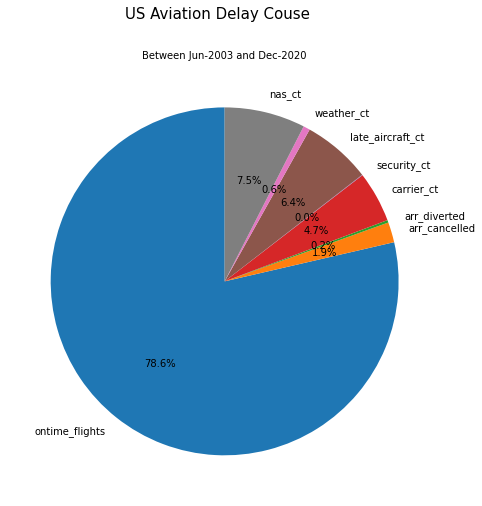

In [35]:
plt.figure(figsize=(8,8))
(df[["ontime_flights", "arr_cancelled","arr_diverted","carrier_ct","security_ct","late_aircraft_ct","weather_ct","nas_ct"]].sum() / df.arr_flights.sum()*100)\
.plot.pie( autopct='%1.1f%%', startangle=90)
plt.ylabel("")
plt.suptitle("US Aviation Delay Couse", fontsize=15)
plt.title("Between Jun-2003 and Dec-2020", fontsize=10);

In [36]:

def graph_bar_pct(data, colors):
    fig, ax = plt.subplots(figsize=(18,6))
    
    for col,color in zip(cols, colors):
    
        sns.set_color_codes(color)    
        ax = sns.barplot(x=data.index, y=col, data=data,     label=f"{col}", color="b", )
        ax.set_ylabel("Percentage")

        for container in ax.containers:
            ax.bar_label(container, fmt='%.0f%%')
            
        ax.legend(loc='best', bbox_to_anchor=(1.05, 1.0))   
    

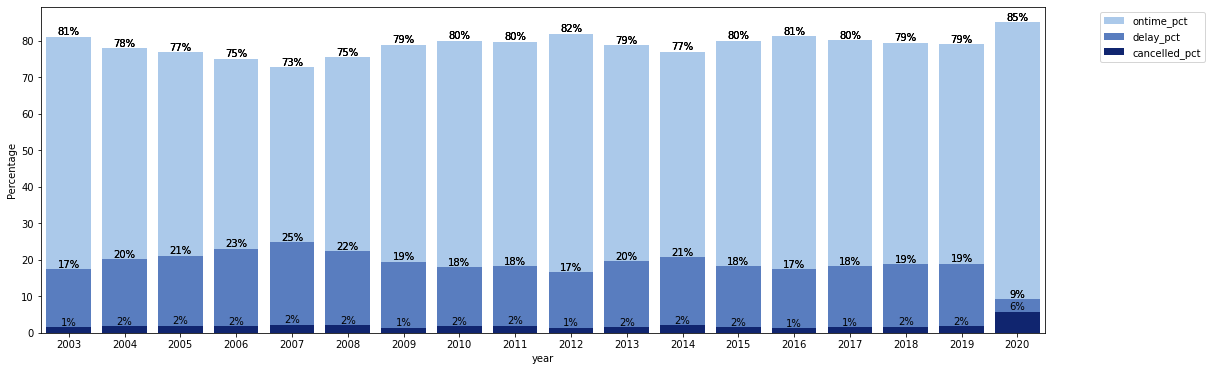

In [37]:
cols = ["ontime_pct","delay_pct", "cancelled_pct" ]
    
colors = ["pastel", "muted", "dark", "bright", "deep", "colorblind"]

data = df.groupby("year").sum()
data['ontime_pct'] = data['ontime_flights']/data['arr_flights']*100
data['delay_pct'] = data['arr_del15']/data['arr_flights']*100
data['cancelled_pct'] = data['arr_cancelled']/data['arr_flights']*100
                    
graph_bar_pct(data, colors)

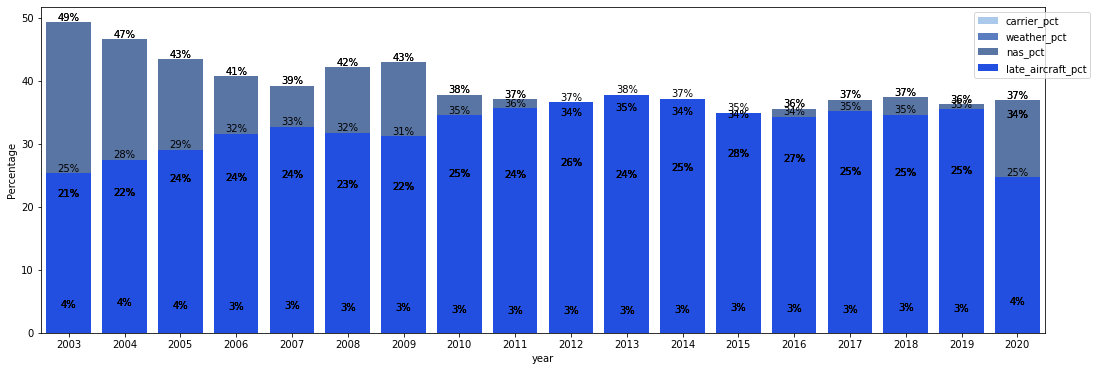

In [38]:
cols = ["carrier_pct","weather_pct", "nas_pct" , "late_aircraft_pct"]  
colors = ["pastel", "muted", "deep",  "bright", "colorblind", "hls",]

data = df.groupby("year").sum()
data['carrier_pct'] = data['carrier_ct']/data['arr_del15']*100
data['weather_pct'] = data['weather_ct']/data['arr_del15']*100
data['nas_pct'] = data['nas_ct']/data['arr_del15']*100
data['security_pct'] = data['security_ct']/data['arr_del15']*100
data['late_aircraft_pct'] = data['late_aircraft_ct']/data['arr_del15']*100
                    
graph_bar_pct(data,colors)

In [39]:
def graph_line(x,y):
    
    fig, ax = plt.subplots(figsize=(24, 8))
    ax.plot(x,y,)
    ax.axvline(pd.Timestamp("2020-01-01"), color="gray", alpha=0.5)
    ax.axvline(pd.Timestamp("2020-04-01"), color="gray", alpha=0.5)

    ax.xaxis.set_major_locator(dates.MonthLocator())
    ax.xaxis.set_major_formatter(dates.DateFormatter("%b"))
    ax.xaxis.set_minor_locator(dates.YearLocator())
    ax.xaxis.set_minor_formatter(dates.DateFormatter("\n\n%Y"))

    ax.xaxis.set_major_locator(MaxNLocator(36))

    return fig, ax

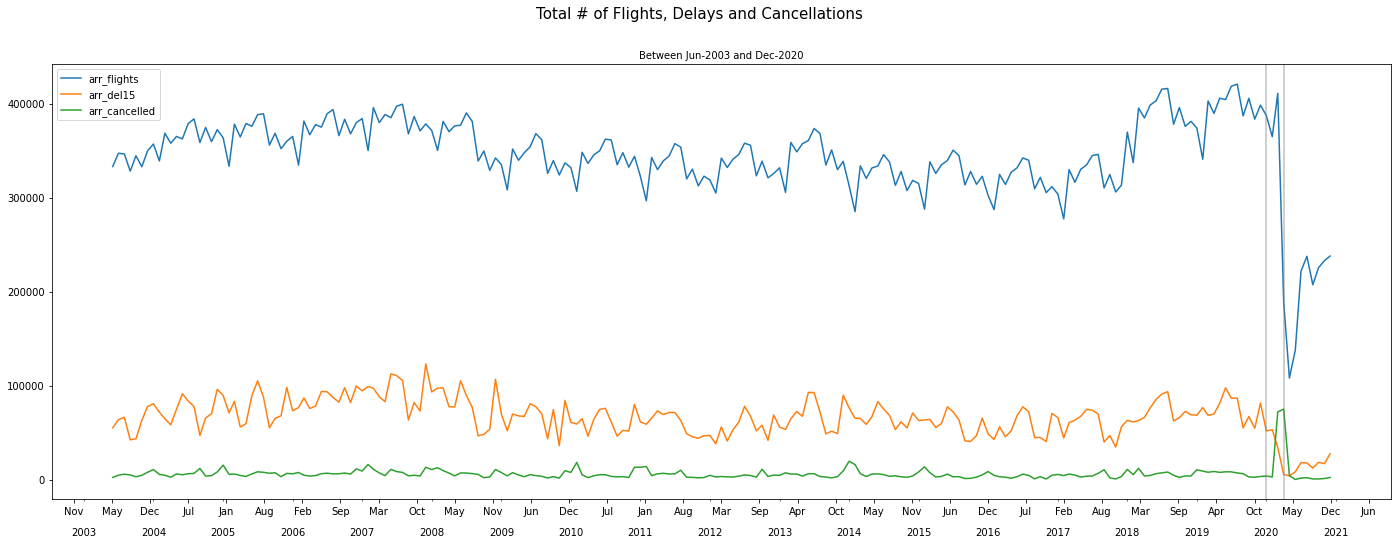

In [40]:
graph_line(df.groupby(df.index).sum().index,df.groupby(df.index).sum()[["arr_flights", "arr_del15", "arr_cancelled"]])

plt.suptitle("Total # of Flights, Delays and Cancellations", fontsize=15)
plt.title("Between Jun-2003 and Dec-2020", fontsize=10)
plt.legend(["arr_flights", "arr_del15", "arr_cancelled"]);


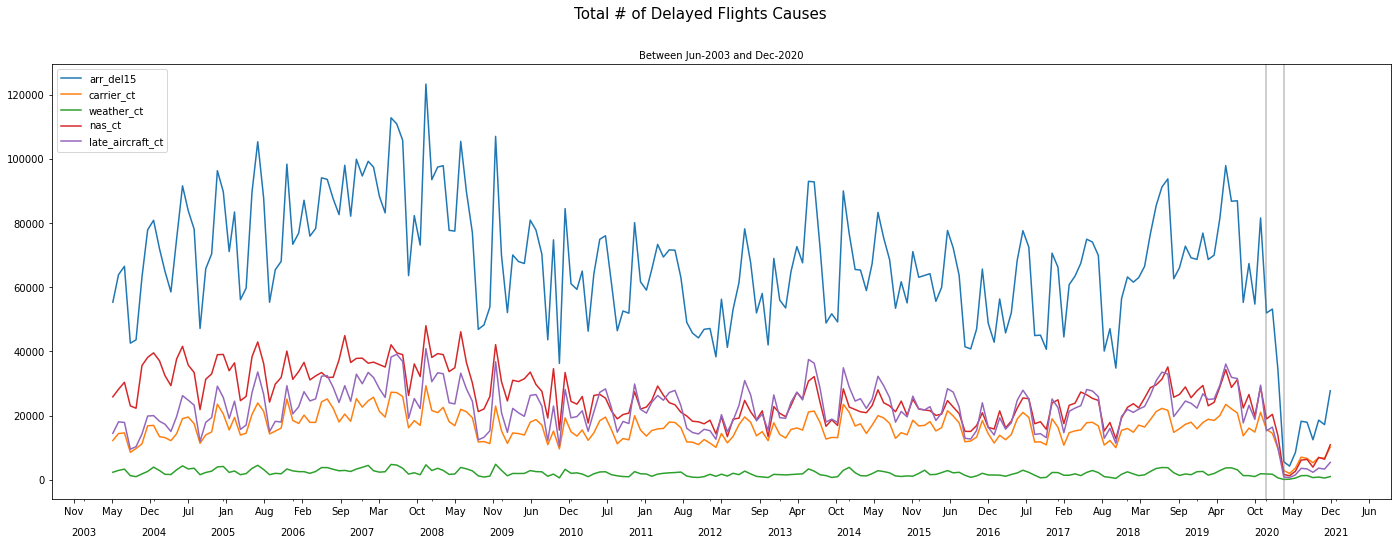

In [41]:
graph_line(df.groupby(df.index).sum().index,df.groupby(df.index).sum()[["arr_del15", "carrier_ct", "weather_ct", "nas_ct", "late_aircraft_ct"]])
plt.legend(["arr_del15", "carrier_ct", "weather_ct", "nas_ct", "late_aircraft_ct"]);
plt.suptitle("Total # of Delayed Flights Causes", fontsize=15)
plt.title("Between Jun-2003 and Dec-2020", fontsize=10);

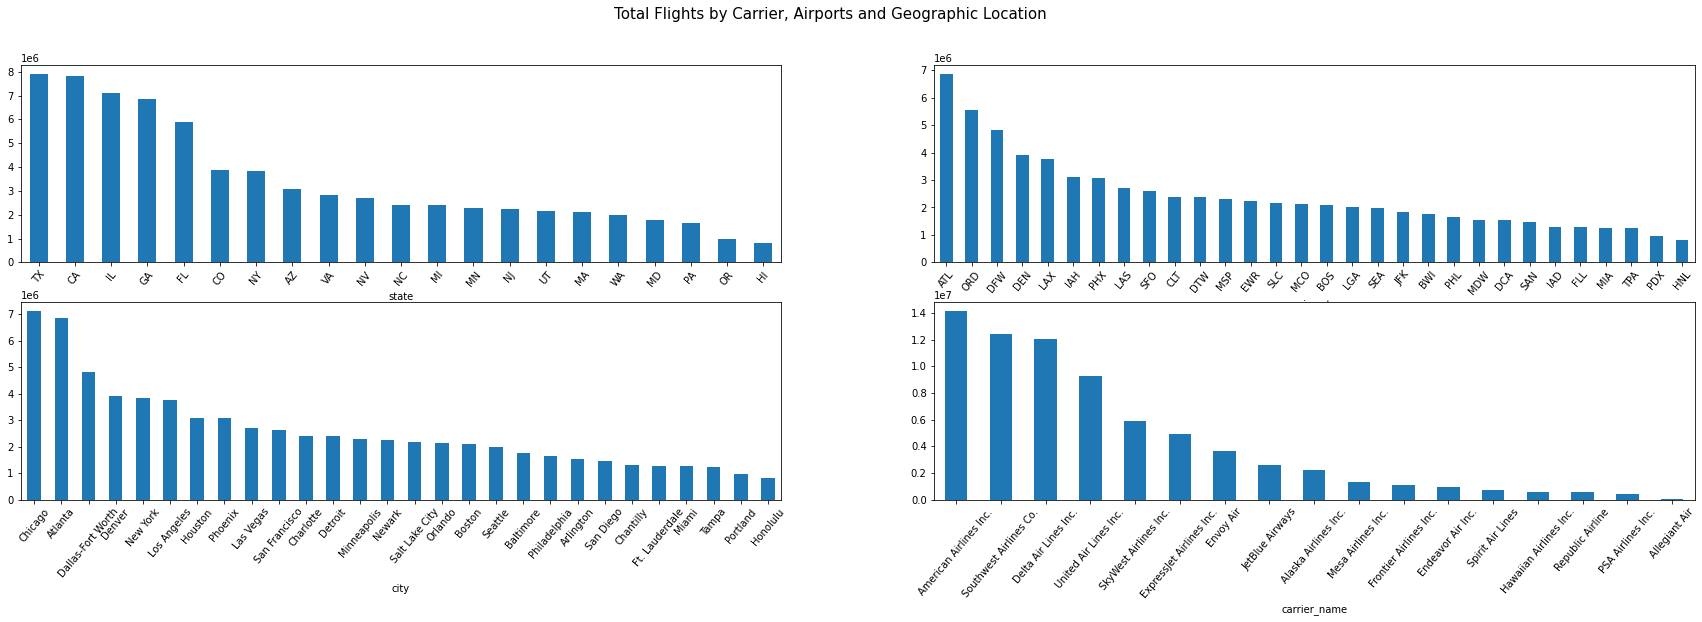

In [42]:
plt.figure(figsize=(30,8))
cols = [  "state", "airport", "city", "carrier_name", ]
plt.suptitle("Total Flights by Carrier, Airports and Geographic Location", fontsize=15)

for i, j in enumerate(cols):
    plt.subplot(2,2,i+1)
    df.groupby(j).sum()["arr_flights"].sort_values(ascending=False).plot(kind="bar")
    plt.xticks(rotation=50);

In [43]:
graph_data = df.groupby("year").sum()[["arr_flights", "ontime_flights", "arr_cancelled","arr_del15","arr_diverted","carrier_ct","security_ct","late_aircraft_ct","weather_ct","nas_ct"]]
graph_data.iloc[:,5:10] = np.round(graph_data.iloc[:,5:10].div(graph_data.arr_del15, axis=0)*100,2)
graph_data.iloc[:,1:5] = np.round(graph_data.iloc[:,1:5].div(graph_data.arr_flights, axis=0)*100,2)
graph_data_1 = graph_data.iloc[:,1:5]
graph_data_2 = graph_data.iloc[:,5:10]

graph_carrier = df.groupby("carrier_name").sum()[["arr_flights", "ontime_flights", "arr_cancelled","arr_del15","arr_diverted","carrier_ct","security_ct","late_aircraft_ct","weather_ct","nas_ct"]]
graph_carrier.iloc[:,5:10] = np.round(graph_carrier.iloc[:,5:10].div(graph_carrier.arr_del15, axis=0)*100,2)
graph_carrier.iloc[:,1:5] = np.round(graph_carrier.iloc[:,1:5].div(graph_carrier.arr_flights, axis=0)*100,2)
graph_carrier = graph_carrier.iloc[:,1:5]

graph_airport = df.groupby("airport").sum()[["arr_flights", "ontime_flights", "arr_cancelled","arr_del15","arr_diverted","carrier_ct","security_ct","late_aircraft_ct","weather_ct","nas_ct"]]
graph_airport.iloc[:,5:10] = np.round(graph_airport.iloc[:,5:10].div(graph_airport.arr_del15, axis=0)*100,2)
graph_airport.iloc[:,1:5] = np.round(graph_airport.iloc[:,1:5].div(graph_airport.arr_flights, axis=0)*100,2)
graph_airport = graph_airport.iloc[:,1:5]

In [44]:
def stacked_graph(graph_data):
    category_names = list(graph_data.columns)
    labels = list(graph_data.index.unique())
    data = graph_data.to_numpy()
    data_cum = data.cumsum(axis=1)
    category_colors = plt.get_cmap('RdYlGn')(np.linspace(0.15, 0.85, data.shape[1]))

    fig, ax = plt.subplots(figsize=(24, 8))
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())
    ax.yaxis.set_major_locator(MaxNLocator())

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        rects = ax.barh(labels, widths, left=starts, height=0.8,label=colname, color=color)

        r, g, b, _ = color
        text_color = 'black'
        ax.bar_label(rects, label_type='center', color=text_color)
        
    ax.legend(ncol=len(category_names), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='large')

    return fig, ax


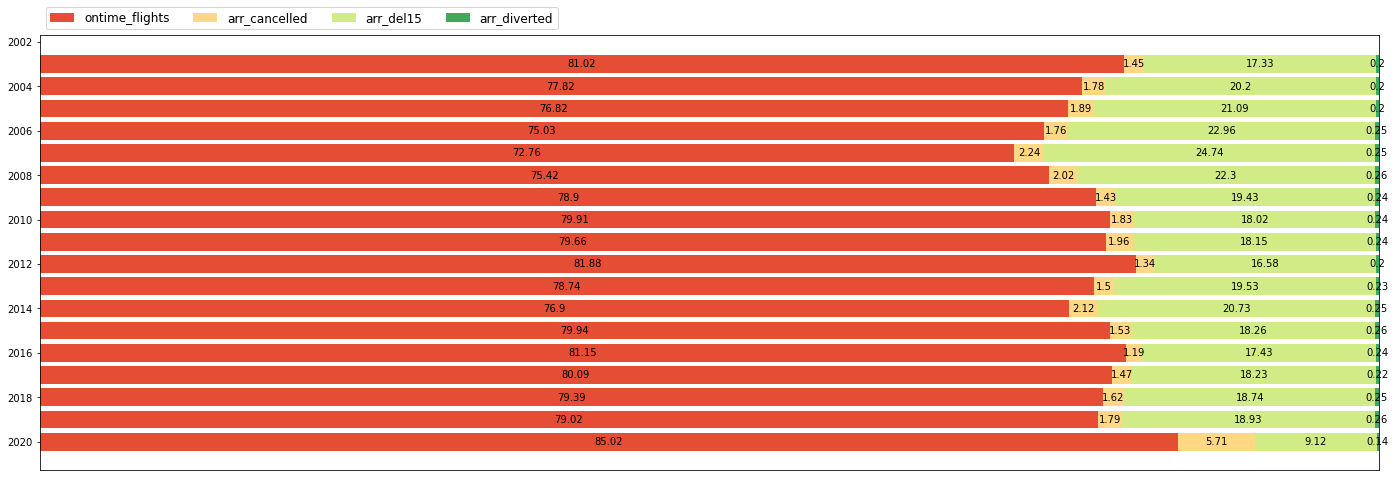

In [45]:

stacked_graph(graph_data_1)
plt.show()

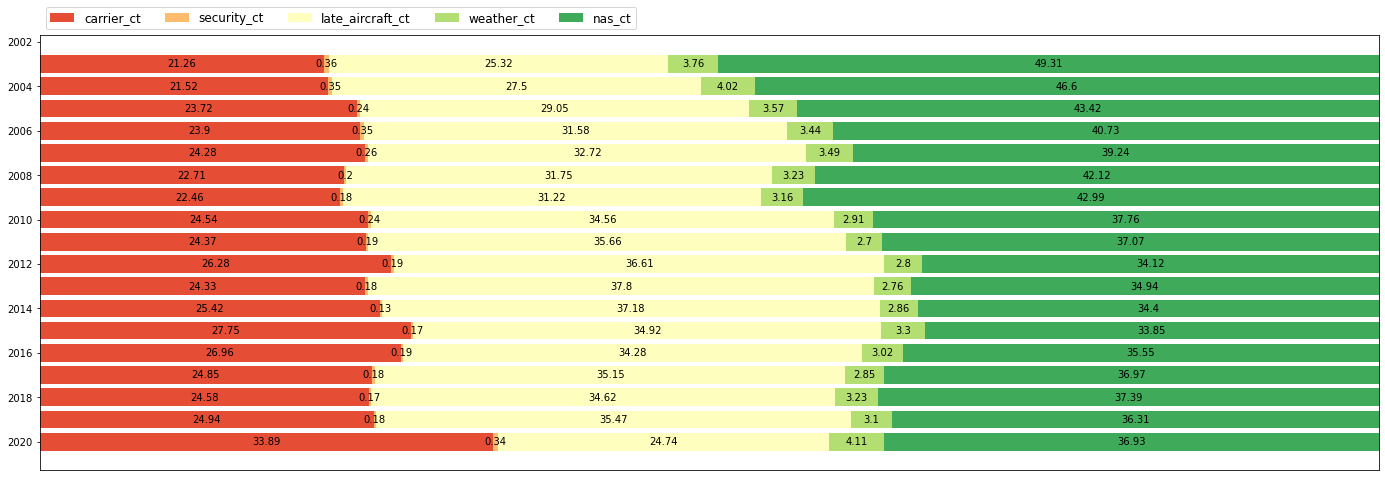

In [46]:
stacked_graph(graph_data_2)
plt.show()

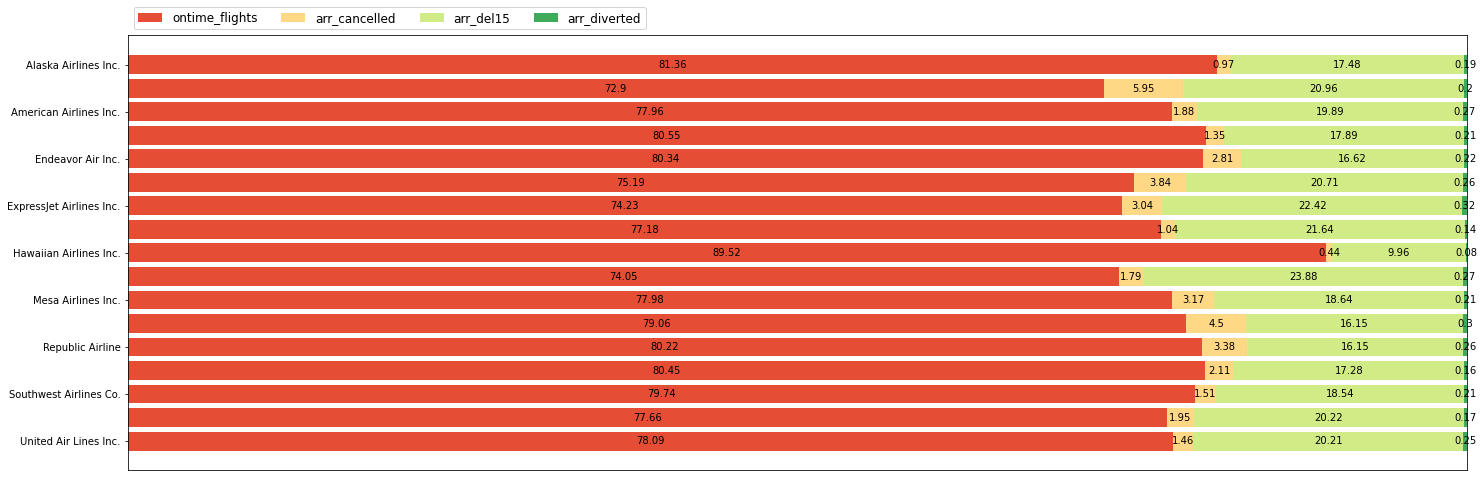

In [47]:
stacked_graph(graph_carrier)
plt.show()

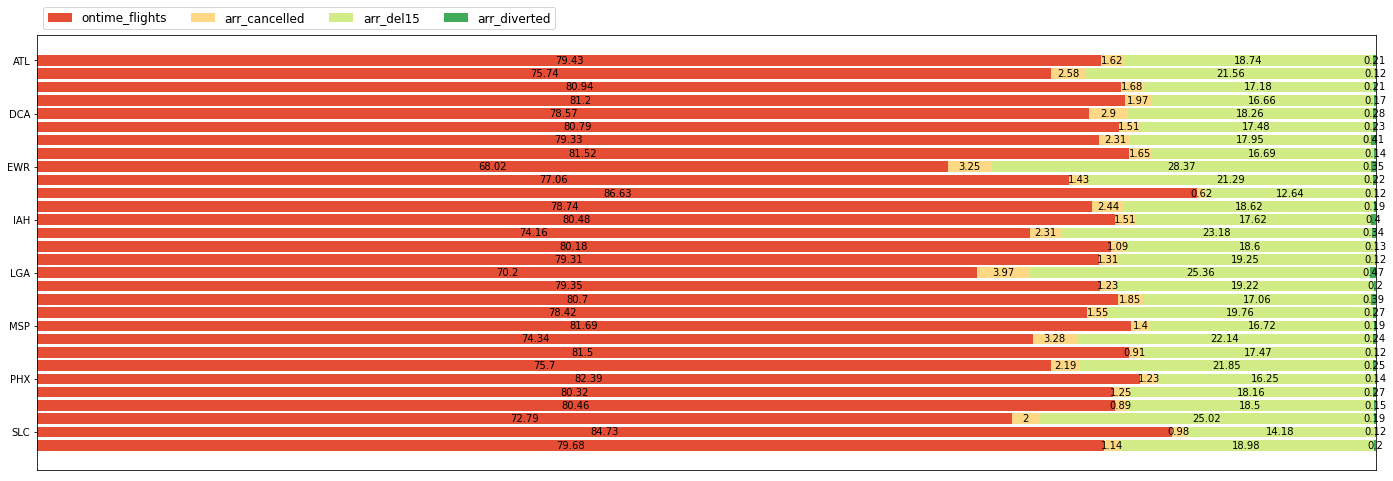

In [48]:
stacked_graph(graph_airport)
plt.show()

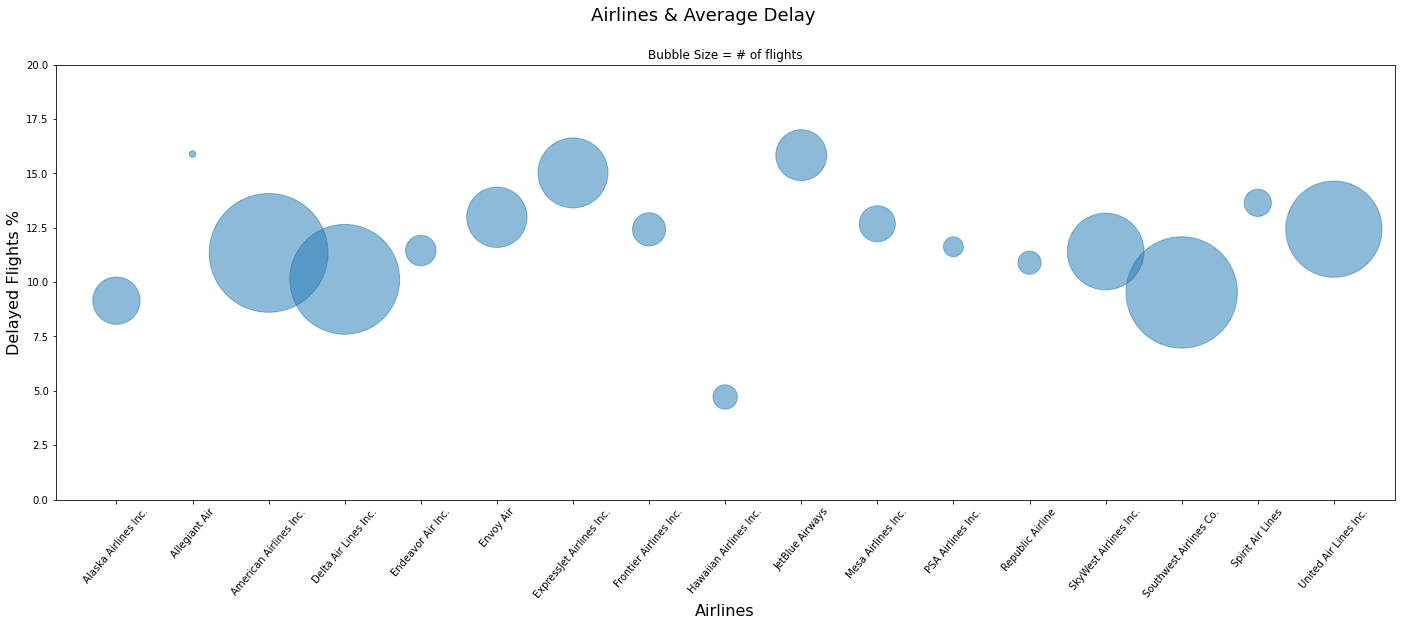

In [49]:
plt.figure(figsize=(24,8))

plt.scatter(y=df.groupby(["carrier_name"]).sum()["arr_delay"] / df.groupby(["carrier_name"]).sum()["arr_flights"], x=df.groupby(["carrier_name"]).sum()["arr_del15"].index,
            s=df.groupby(["carrier_name"]).sum()["arr_flights"]*0.001,  alpha=0.5, )
plt.xlabel("Airlines", size=16)
plt.ylabel("Delayed Flights %", size=16)
plt.ylim([0,20])
plt.xticks(fontsize=10, rotation=50);
plt.suptitle("Airlines & Average Delay", size=18);
plt.title("Bubble Size = # of flights");


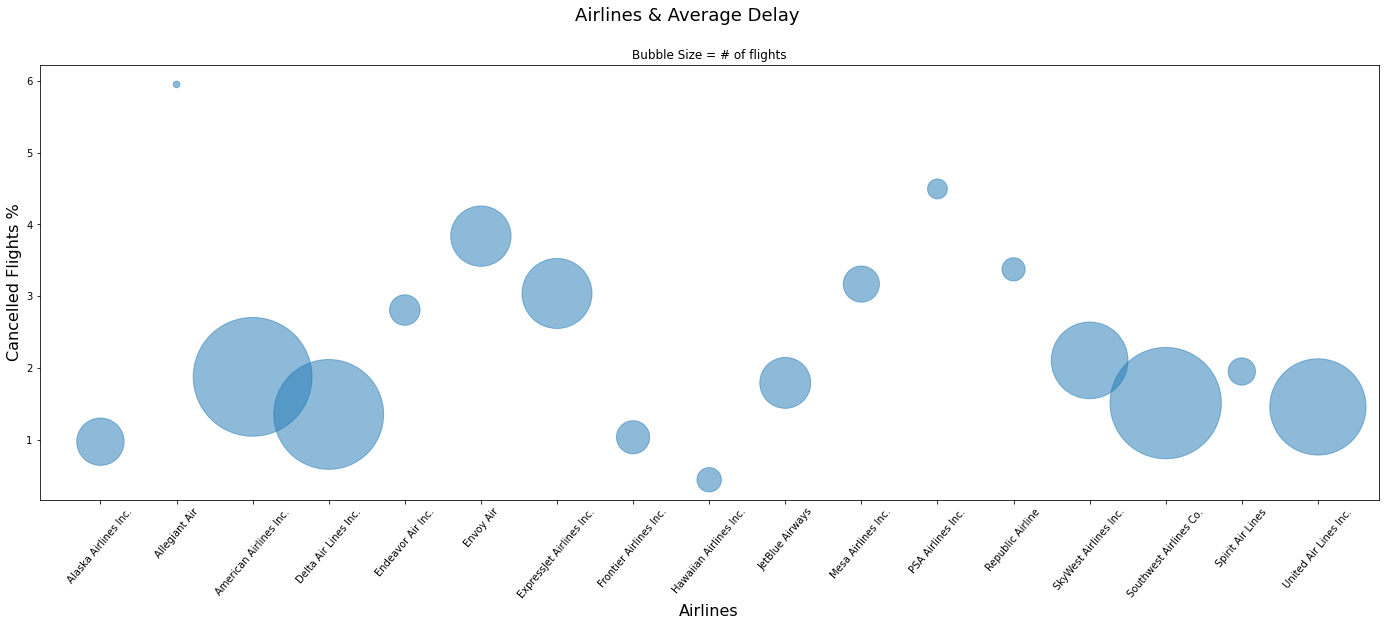

In [50]:
plt.figure(figsize=(24,8))

plt.scatter(y=df.groupby(["carrier_name"]).sum()["arr_cancelled"] / df.groupby(["carrier_name"]).sum()["arr_flights"]*100, x=df.groupby(["carrier_name"]).sum()["arr_del15"].index,
            s=df.groupby(["carrier_name"]).sum()["arr_flights"]*0.001,  alpha=0.5, )
plt.xlabel("Airlines", size=16)
plt.ylabel("Cancelled Flights %", size=16)
plt.xticks(fontsize=10, rotation=50);
plt.suptitle("Airlines & Average Delay", size=18);
plt.title("Bubble Size = # of flights");


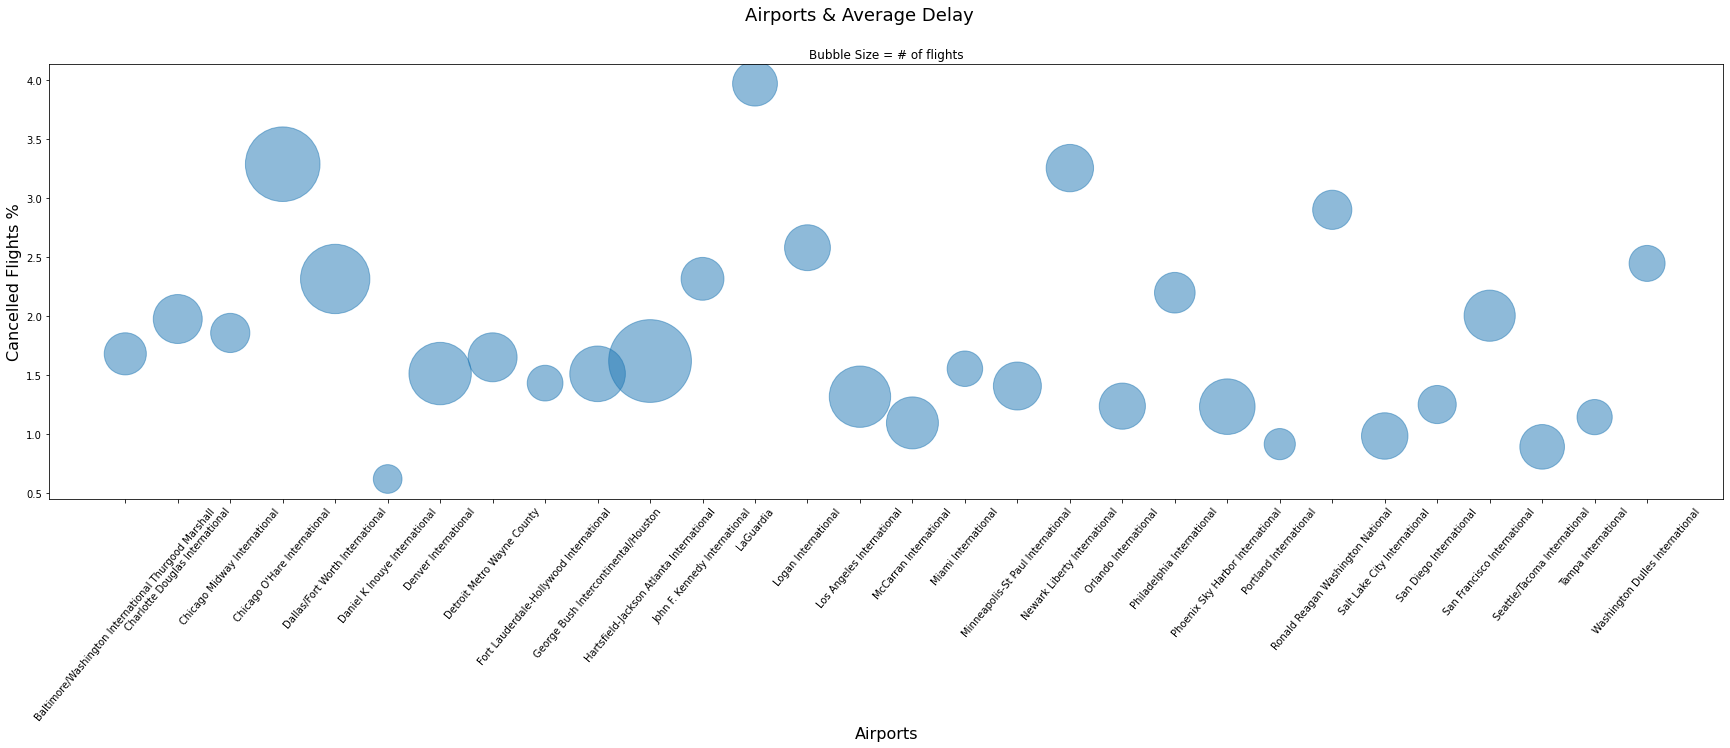

In [51]:
plt.figure(figsize=(30,8))

plt.scatter(y=df.groupby(["airport_name"]).sum()["arr_cancelled"] / df.groupby(["airport_name"]).sum()["arr_flights"]*100, x=df.groupby(["airport_name"]).mean()["arr_del15"].index,
            s=df.groupby(["airport_name"]).sum()["arr_flights"]*0.001, alpha=0.5, )
            
plt.xlabel("Airports", size=16)
plt.ylabel("Cancelled Flights %", size=16)

plt.xticks(fontsize=10, rotation=50);
plt.suptitle("Airports & Average Delay", size=18);
plt.title("Bubble Size = # of flights");


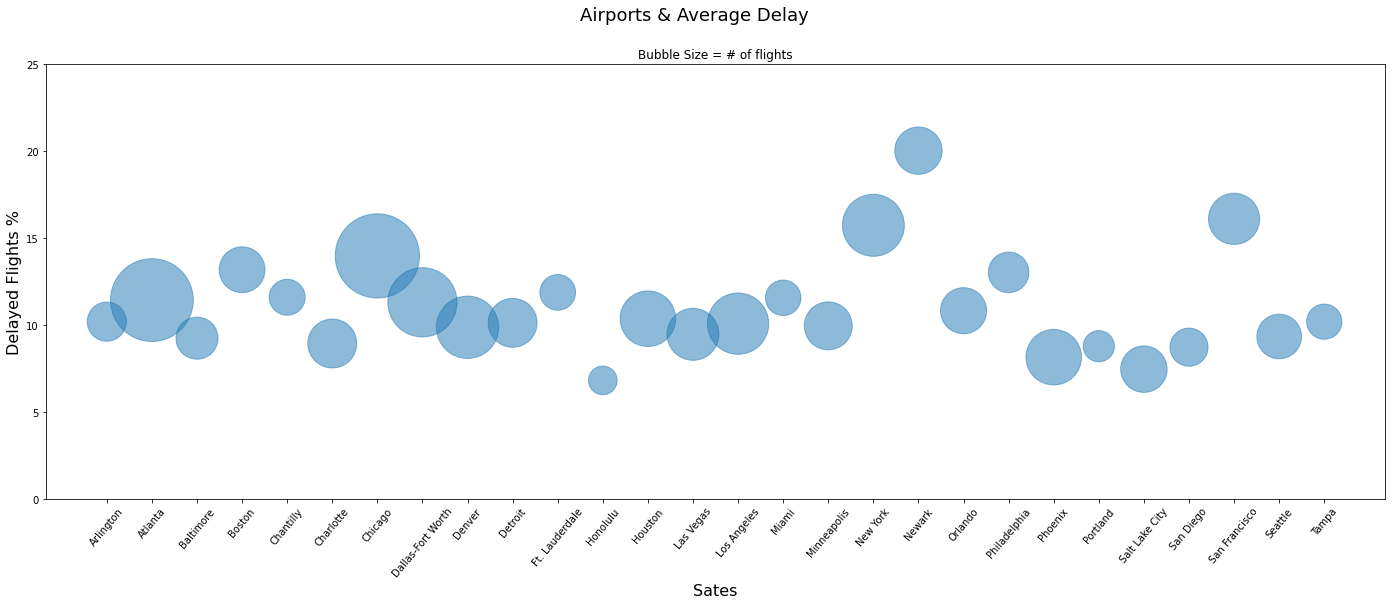

In [52]:
plt.figure(figsize=(24,8))

plt.scatter(y=df.groupby(["city"]).sum()["arr_delay"] / df.groupby(["city"]).sum()["arr_flights"], x=df.groupby(["city"]).mean()["arr_del15"].index,
            s=df.groupby(["city"]).sum()["arr_flights"]*0.001, alpha=0.5, )
            
plt.xlabel("Sates", size=16)
plt.ylabel("Delayed Flights %", size=16)
plt.ylim([0,25])
plt.xticks(fontsize=10, rotation=50);
plt.suptitle("Airports & Average Delay", size=18);
plt.title("Bubble Size = # of flights");


# MacroEconomic Features

In [53]:
macrodata = macrodata.merge(fear_index, how="left", on="year_month").dropna()
macrodata.set_index("year_month", inplace=True)

macro_cols = list(macrodata.columns)
macro_cols.append("arr_flights")

In [54]:
df_grouped_wc = df.groupby(df.index).sum().merge(macrodata, how="left", on="year_month").dropna()
df_grouped_wc.drop([ "delayed", "ontime_flights", "arr_diverted", "latitude", "longitude", "arr_del15","year", "month"], axis=1, inplace=True)
df_grouped_wc.drop(ct_cols, axis=1, inplace=True)
df_grouped_wc.drop(delay_cols, axis=1, inplace=True)

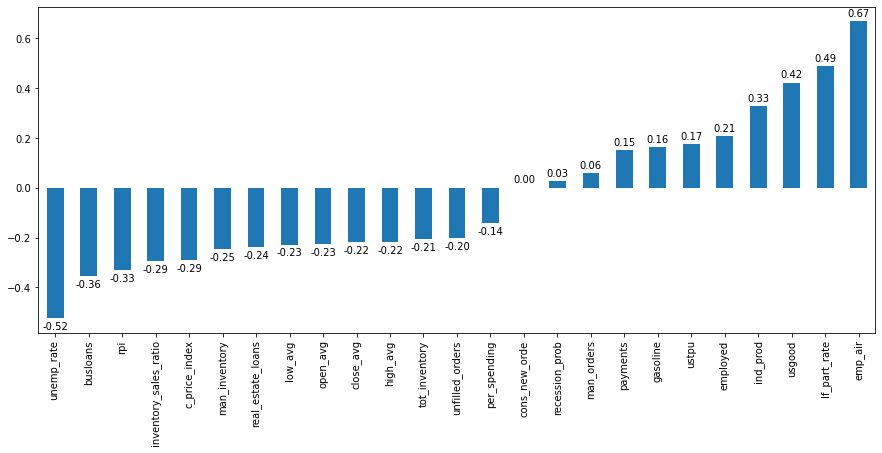

In [55]:
ax = df_grouped_wc[macro_cols].corr()["arr_flights"].sort_values()[:-1].plot(kind="bar", figsize=(15,6))
ax.bar_label(ax.containers[0], fmt="%.2f", label_type="edge", padding=3);

In [56]:
cols_drop = [df_grouped_wc.columns[i] for i in range(df_grouped_wc.shape[1]-1) if np.abs(df_grouped_wc.corr()["arr_flights"][i])<0.3]
cols_drop

['arr_cancelled',
 'employed',
 'payments',
 'gasoline',
 'ustpu',
 'per_spending',
 'man_inventory',
 'man_orders',
 'cons_new_orde',
 'unfilled_orders',
 'tot_inventory',
 'inventory_sales_ratio',
 'real_estate_loans',
 'c_price_index',
 'recession_prob',
 'open_avg',
 'low_avg',
 'high_avg']

In [57]:
cols_drop = ['arr_cancelled',
 'employed',
 'payments',
 'gasoline',
 'ustpu',
 'per_spending',
 'man_inventory',
 'man_orders',
 'cons_new_orde',
 'unfilled_orders',
 'tot_inventory',
 'inventory_sales_ratio',
 'real_estate_loans',
 'c_price_index',
 #'recession_prob',
 'open_avg',
 'low_avg',
 'high_avg']
df_grouped_wc.drop(cols_drop, axis=1, inplace=True)

In [58]:
df_grouped_wc.head(2)

,arr_flights,rpi,ind_prod,lf_part_rate,unemp_rate,emp_air,usgood,busloans,recession_prob,close_avg
year_month,,,,,,,,,,
2003-06-01,333348.0,11544.701,90.7372,66.5,6.3,520.4,21788,917.3746,0.2,20.36
2003-07-01,347438.0,11556.121,91.2028,66.2,6.2,515.1,21708,921.5122,0.1,19.16


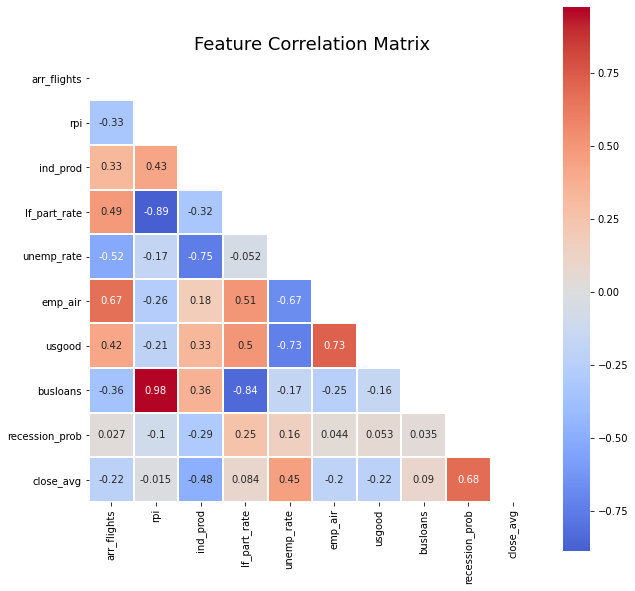

In [59]:
corr = df_grouped_wc.corr()

fig, ax = plt.subplots(figsize=(10 , 10))
mask = np.triu(np.ones_like(corr, dtype = np.bool))

sns.heatmap(corr,square = True, center = 0, annot=True,
            linewidth = 0.2, cmap = "coolwarm",
           mask = mask, ax = ax) 

ax.set_title("Feature Correlation Matrix", loc = "center", fontsize=18)
plt.show()


## >60 strong correlation

In [60]:
df_grouped_wc = df_grouped_wc.drop(['usgood', "busloans", "rpi" , "ind_prod" , ], axis=1)

<AxesSubplot:xlabel='year_month'>

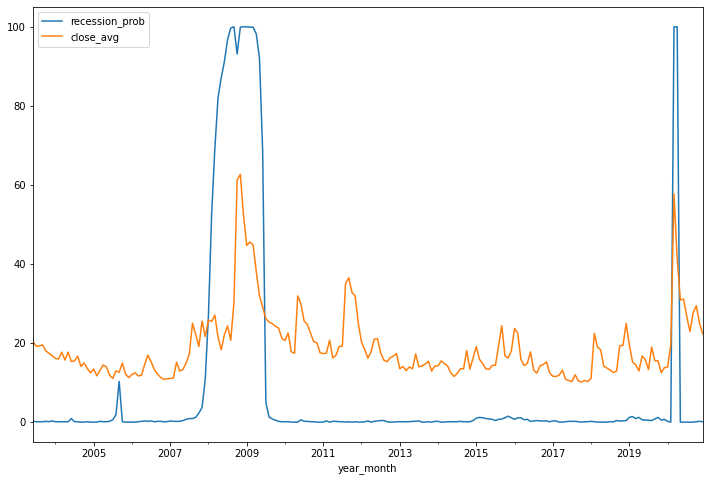

In [61]:
df_grouped_wc[['recession_prob', 'close_avg']].plot()

In [62]:
useful_features = list(df_grouped_wc.columns[1:])
useful_features

['lf_part_rate', 'unemp_rate', 'emp_air', 'recession_prob', 'close_avg']

In [63]:
df_grouped_wc.columns

Index(['arr_flights', 'lf_part_rate', 'unemp_rate', 'emp_air',
       'recession_prob', 'close_avg'],
      dtype='object')

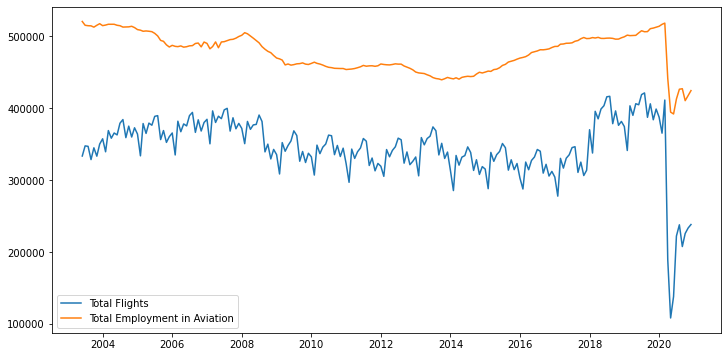

In [64]:
fig= plt.figure(figsize=(12,6))
ax = fig.subplots()

ax.plot(df_grouped_wc.index, df_grouped_wc[["arr_flights",]], label="Total Flights")
ax.plot(df_grouped_wc.index, df_grouped_wc[["emp_air"]]*1000, label="Total Employment in Aviation" )
ax.legend();

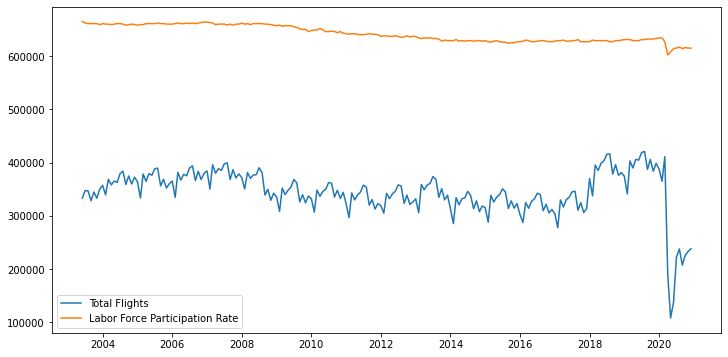

In [65]:
fig= plt.figure(figsize=(12,6))
ax = fig.subplots()

ax.plot(df_grouped_wc.index, df_grouped_wc[["arr_flights",]], label="Total Flights")
ax.plot(df_grouped_wc.index, df_grouped_wc[["lf_part_rate"]]*10000, label="Labor Force Participation Rate" )
ax.legend();

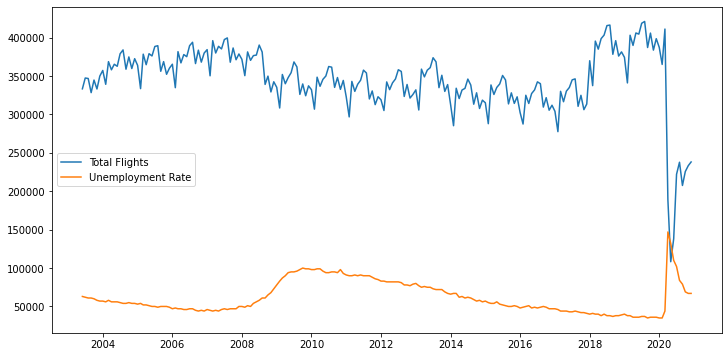

In [66]:
fig= plt.figure(figsize=(12,6))
ax = fig.subplots()

ax.plot(df_grouped_wc.index, df_grouped_wc[["arr_flights",]], label="Total Flights")
ax.plot(df_grouped_wc.index, df_grouped_wc[["unemp_rate"]]*10000, label="Unemployment Rate" )
ax.legend();

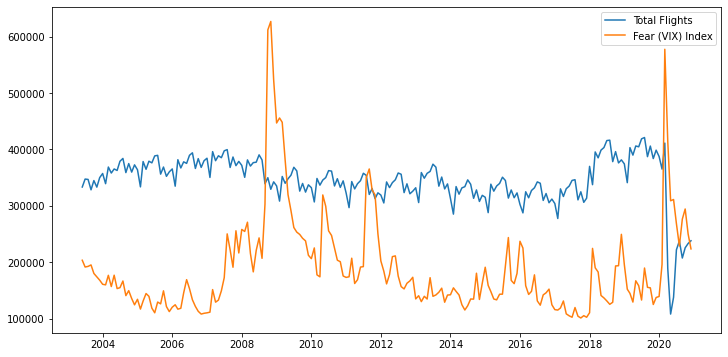

In [67]:
fig= plt.figure(figsize=(12,6))
ax = fig.subplots()

ax.plot(df_grouped_wc.index, df_grouped_wc[["arr_flights",]], label="Total Flights")
ax.plot(df_grouped_wc.index, df_grouped_wc[["close_avg"]]*10000, label="Fear (VIX) Index" )
ax.legend();

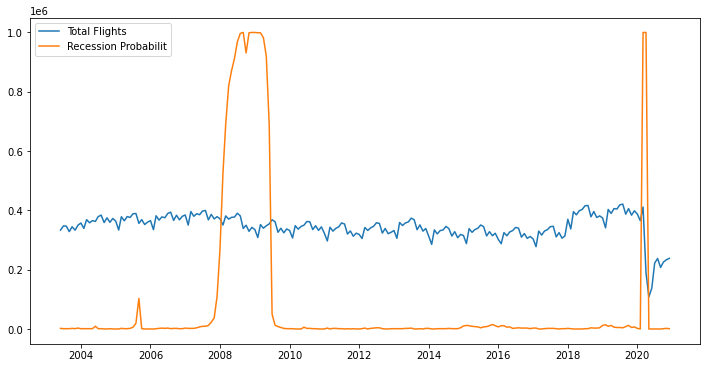

In [68]:
fig= plt.figure(figsize=(12,6))
ax = fig.subplots()

ax.plot(df_grouped_wc.index, df_grouped_wc[["arr_flights",]], label="Total Flights")
ax.plot(df_grouped_wc.index, df_grouped_wc[["recession_prob"]]*10000, label="Recession Probabilit" )
ax.legend();

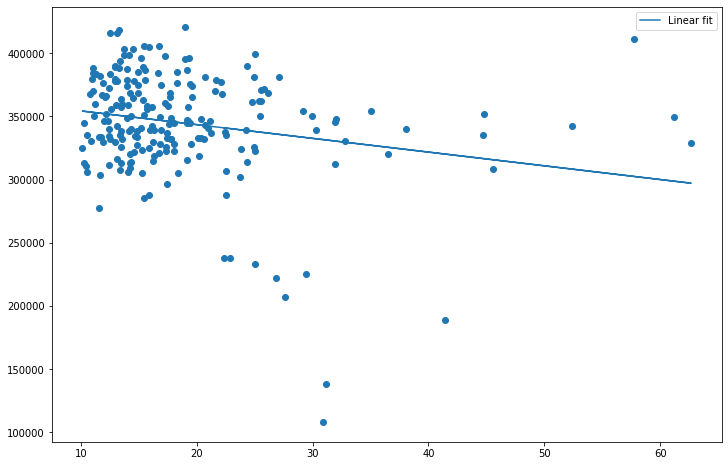

In [69]:
fig = plt.figure()
ax = fig.subplots()

ax.scatter( df_grouped_wc[[ "close_avg"]], df_grouped_wc[["arr_flights",]])
a, b = np.polyfit(x=(df_grouped_wc[[ "close_avg"]].values.flatten()), y=df_grouped_wc[["arr_flights",]].values.flatten(),  deg=1)
pred = a*df_grouped_wc[["close_avg",]]+b
ax.plot(df_grouped_wc[["close_avg",]], pred, label="Linear fit")   

ax.legend();

# Distribution of Features

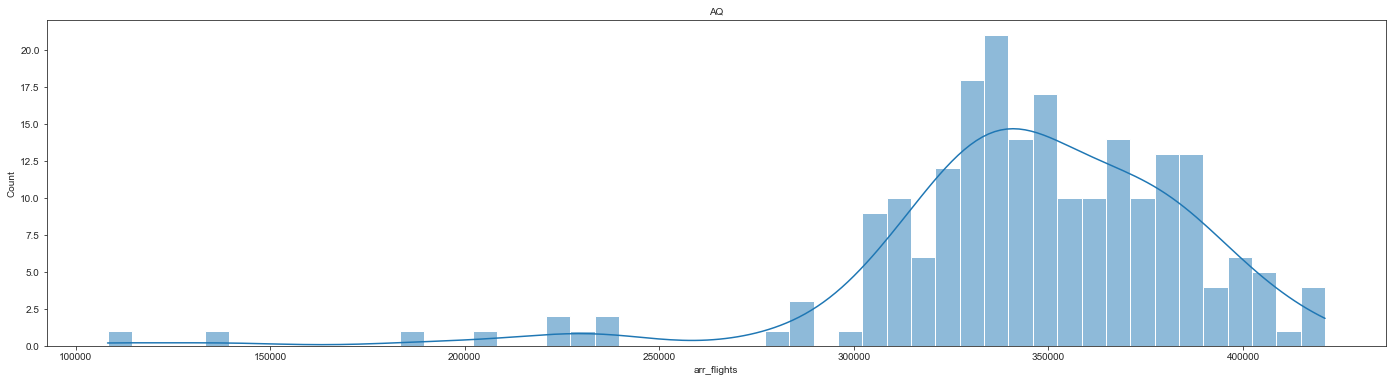

In [70]:
plt.figure(figsize=(24,6))

sns.set_style("ticks")
sns.histplot(df_grouped_wc["arr_flights"], bins=50, kde=True )
plt.title(f"{col}", fontsize=10 )
plt.subplots_adjust(hspace=0.6)

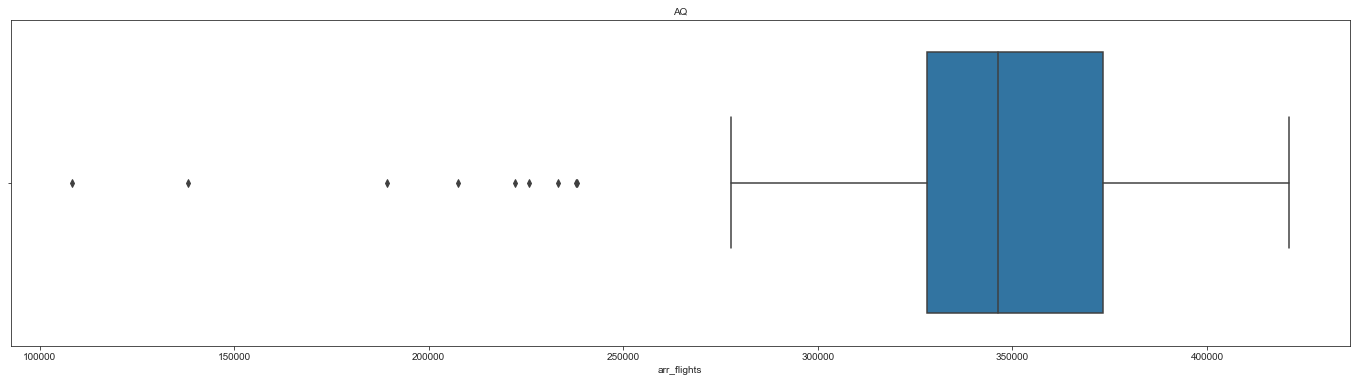

In [71]:
plt.figure(figsize=(24,6))

sns.set_style("ticks")
sns.boxplot(df_grouped_wc["arr_flights"] )
plt.title(f"{col}", fontsize=10 )
plt.subplots_adjust(hspace=0.6)

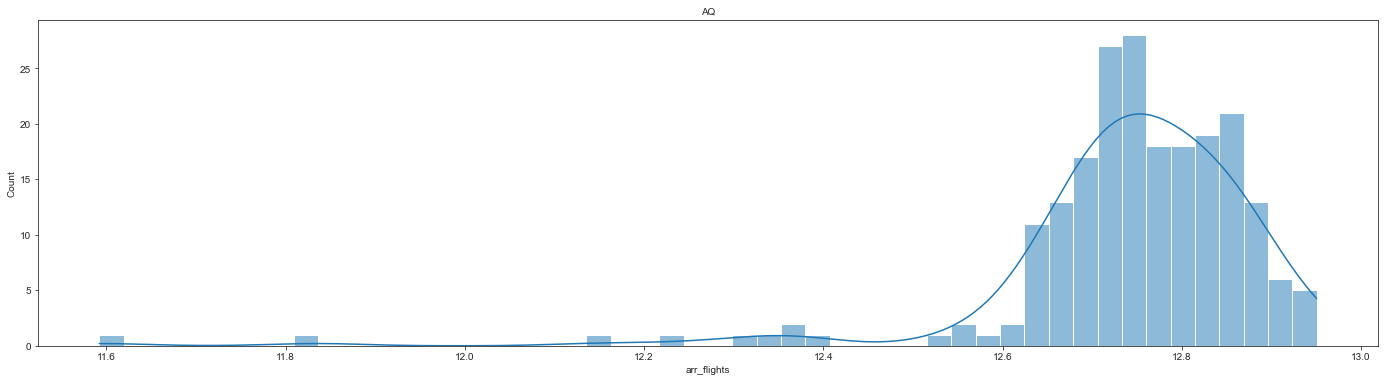

In [72]:
plt.figure(figsize=(24,6))

sns.set_style("ticks")
sns.histplot(np.log(df_grouped_wc["arr_flights"]), bins=50, kde=True )
plt.title(f"{col}", fontsize=10 )
plt.subplots_adjust(hspace=0.6)

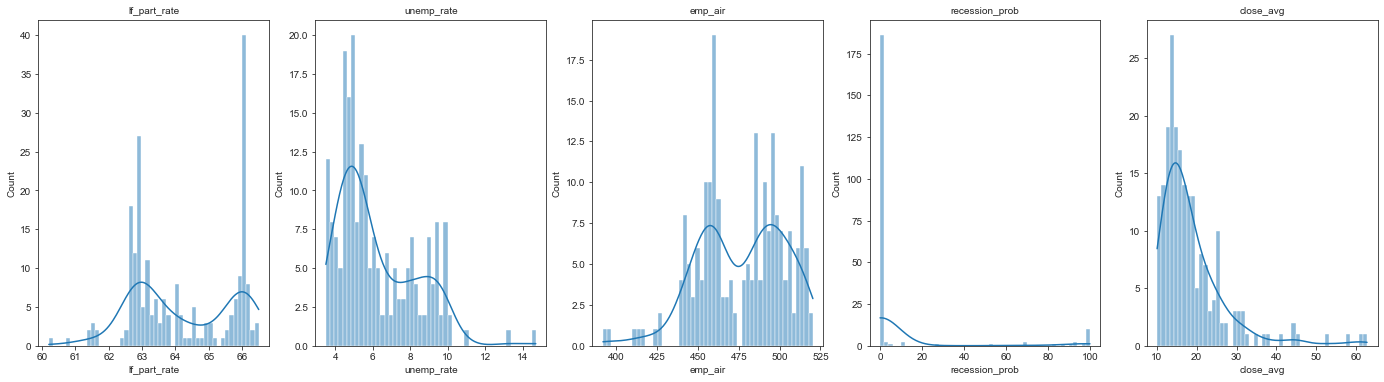

In [73]:
plt.figure(figsize=(24,6))

for idx, col in enumerate(list(df_grouped_wc.columns[1:])):
    sns.set_style("ticks")
    plt.subplot(1,5,idx+1)
    sns.histplot(df_grouped_wc[col], bins=50, kde=True )
    plt.title(f"{col}", fontsize=10 )
    plt.subplots_adjust(hspace=0.6)

# Data Preprocessing

At this step conduct necessary transformations (e.g., one-hot-encoding and scaling), handling of missing data (if relevant), and other steps to prepare the training data for a model.

In [74]:
df_grouped_wc.index.freq = "MS"

In [75]:
df_forecast = df_grouped_wc.loc['2003-06-01':'2020-12-01']

train = df_grouped_wc.loc[df_grouped_wc.index < "2020-07-01"]
valid = df_grouped_wc.loc[(df_grouped_wc.index >= "2020-07-01") & (df_grouped_wc.index <= "2020-12-01")]
test = macrodata.loc["2021-01-01":"2021-06-01"][['lf_part_rate', 'emp_air',  "recession_prob", 'close_avg', "unemp_rate"]]
test.index.freq = "MS"

train_log = np.log(train)
valid_log = np.log(valid)
test_log = np.log(test)

scaler = StandardScaler()
train_scaled = pd.concat([np.log(train.iloc[:,0]), pd.DataFrame(scaler.fit_transform(train.iloc[:,1:]), index=train.index, columns=train.iloc[:,1:].columns)], axis=1)
valid_scaled = pd.concat([np.log(valid.iloc[:,0]), pd.DataFrame(scaler.fit_transform(valid.iloc[:,1:]), index=valid.index, columns=valid.iloc[:,1:].columns)], axis=1)
test_scaled = pd.concat([np.log(test.iloc[:,0]), pd.DataFrame(scaler.fit_transform(test.iloc[:,1:]), index=test.index, columns=test.iloc[:,1:].columns)], axis=1)

# Modeling

Choose a relevant model and train on the training dataset. Perform additional steps to fine-tune your model as you see fit. Once you are satisfied with your model, evaluate the model on the testing data. Report appropriate model performance metrics and use relevant visualizations as you see fit.

## Exponential Smoothing

In [76]:
def SMAPE( y_true, y_pred):
    denominator = (y_true + np.abs(y_pred)) / 200.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return np.mean(diff)

In [77]:
model_exp = ExponentialSmoothing(train.arr_flights, trend="mul", seasonal="add", seasonal_periods=12, freq="MS").fit()

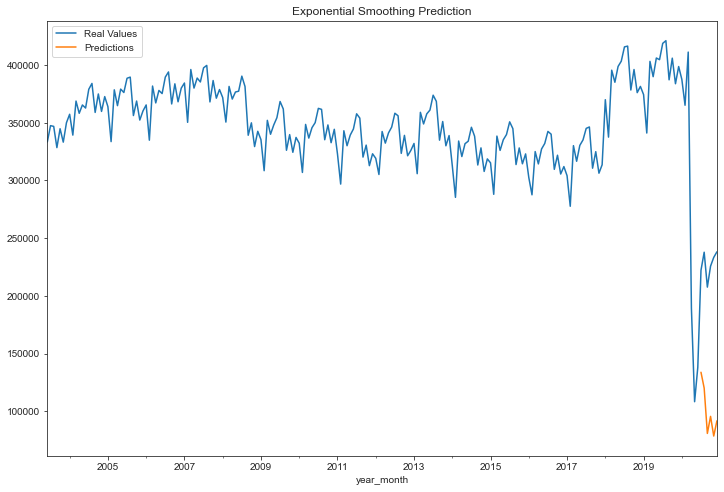

In [78]:
preds_exp = model_exp.forecast(6)  

df_forecast.arr_flights.plot(label="Real Values")
preds_exp.plot(label="Predictions")
plt.title("Exponential Smoothing Prediction")

plt.legend()

In [79]:
print(f"MAE : {mean_absolute_error(valid.arr_flights, preds_exp):4f}")
print(f"RMSE : {np.sqrt(mean_squared_error(valid.arr_flights, preds_exp)):4f}")
print(f"SMAPE : {SMAPE(valid.arr_flights, preds_exp):4f}")

MAE : 127367.928640
RMSE : 129148.910669
SMAPE : 78.758632


In [80]:
results_df = pd.DataFrame(columns = ["MODEL", "RMSE", "MAE",  "SMAPE"])

results_df = results_df.append(pd.DataFrame([["ExpSmooth",
                                              np.sqrt(mean_squared_error(valid.arr_flights, preds_exp)),                                              
                                              mean_absolute_error(valid.arr_flights, preds_exp),
                                              SMAPE(valid.arr_flights, preds_exp)                                              ]],
                                            columns=results_df.columns))
  

## SARIMA

<Figure size 2592x864 with 0 Axes>

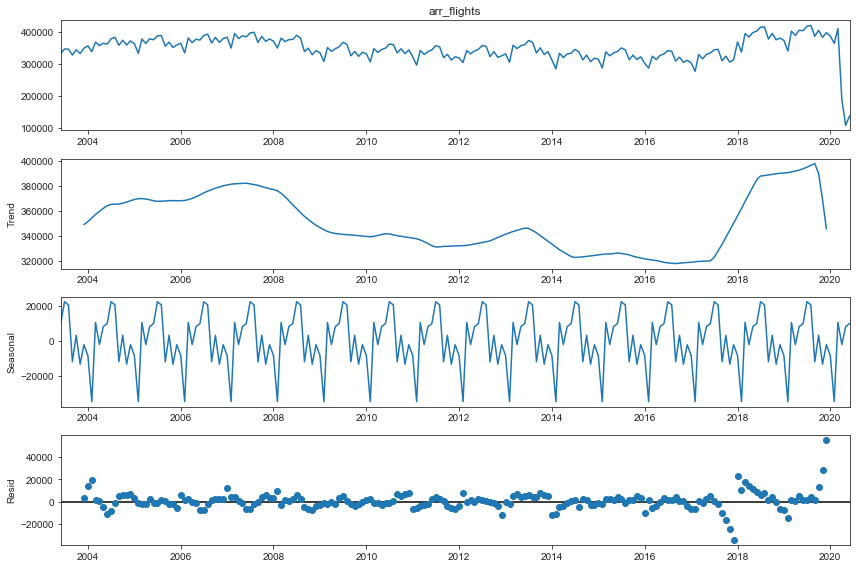

In [81]:
plt.rcParams["figure.figsize"]=(12,8)

plt.figure(figsize=(36,12))
decomp = seasonal_decompose(train.arr_flights,  period=12)
decomp.plot();

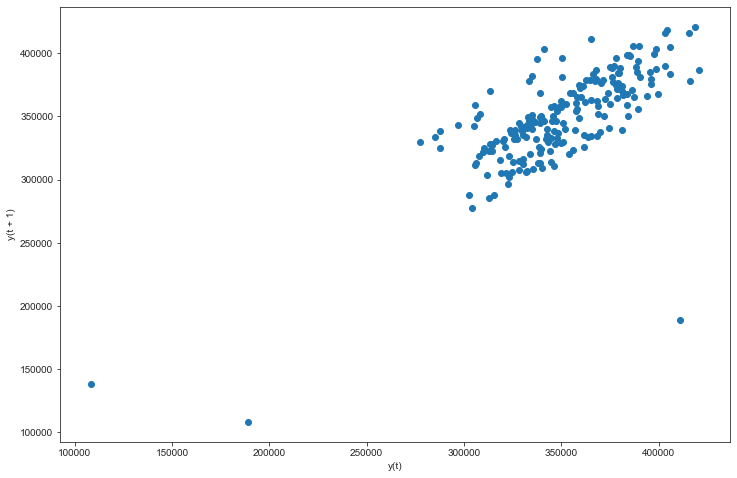

In [82]:
lag_plot(train.arr_flights, lag=1);

### Stationarity

In [83]:
#adfuller(train.arr_flights)
diff_1 = (train.arr_flights -train.arr_flights.shift(12)).dropna()
#diff_2 = (diff_1 - diff_1.shift(12)).dropna()

adfuller(diff_1)


(-2.715756803284846,
 0.07135111677162502,
 15,
 177,
 {'1%': -3.467845319799907,
  '5%': -2.878011745497439,
  '10%': -2.575551186759871},
 3959.7739082211656)

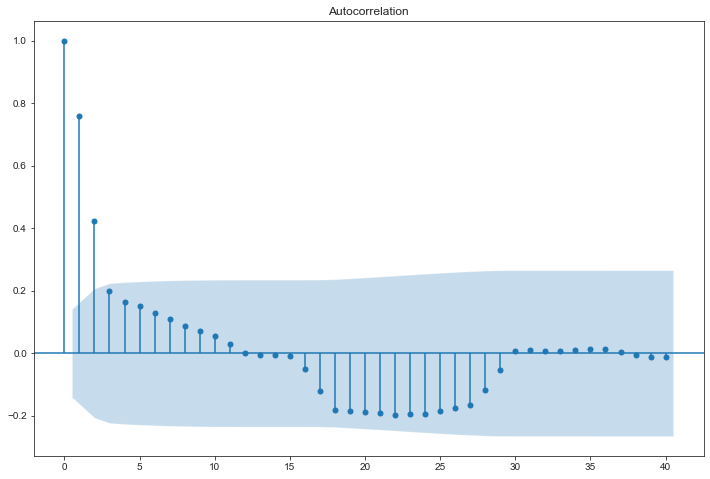

In [84]:
plot_acf(diff_1, lags=40 );

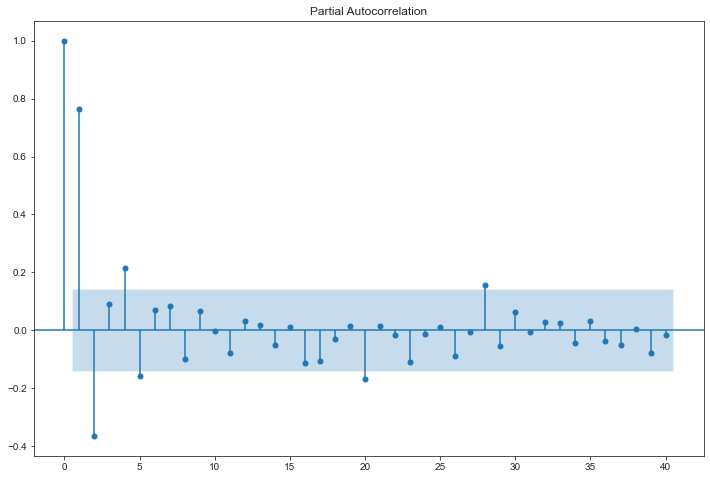

In [85]:
plot_pacf(diff_1, lags=40 );

In [86]:
auto_arima(train.arr_flights, seasonal=True, m=12,stationary=False, maxiter=100).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  205
Model:             SARIMAX(0, 0, 2)x(0, 1, [], 12)   Log Likelihood               -2241.401
Date:                             Thu, 14 Jul 2022   AIC                           4488.802
Time:                                     04:58:52   BIC                           4498.590
Sample:                                          0   HQIC                          4492.766
                                             - 205                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.7900      0.013     59.228      0.000       0.764       0.816
ma.L2          0.4297      0.024     18.269      0.000       0.384       0.476
sigma2      5.169e+08   6.13e-12   8.43e+19      0.000    5.17e+08    5.17e+08
===================================================================================
Ljung-Box (L1) (Q):                  13.82   Jarque-Bera (JB):              7096.85
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.83   Skew:                            -4.03
Prob(H) (two-sided):                  0.02   Kurtosis:                        31.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.05e+36. Standard errors may be unstable.
"""

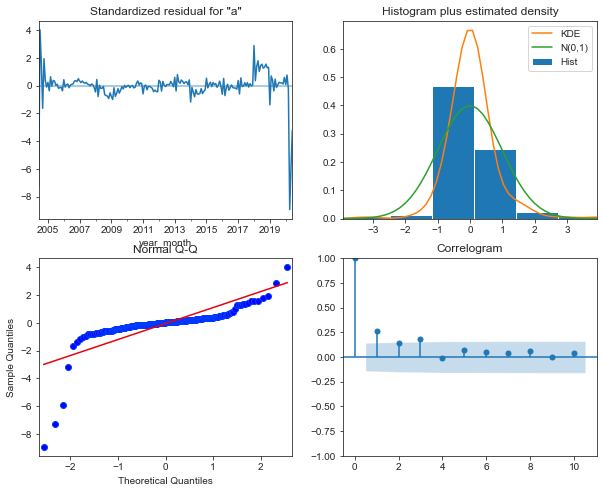

In [87]:
model_sarima = SARIMAX( train.arr_flights, order=(0,0,2),seasonal_order=(0, 1, [], 12) ).fit(disp=False)
model_sarima.plot_diagnostics(figsize=(10,8));

In [88]:
preds_sarima = model_sarima.predict(start=len(train), end=len(train)+len(valid)-1)

In [89]:
print(f"MAE-SARIMA: {mean_absolute_error(valid.arr_flights, preds_sarima):2f}")
print(f"RMSE-SARIMA: {np.sqrt(mean_squared_error(valid.arr_flights, preds_sarima)):2f}")
print(f"SMAPE-SARIMA : {SMAPE(valid.arr_flights, preds_sarima):4f}")
print(f"AIC : {model_sarima.aic:4f}")

MAE-SARIMA: 150683.260675
RMSE-SARIMA: 154309.721362
SMAPE-SARIMA : 49.340860
AIC : 4488.801896


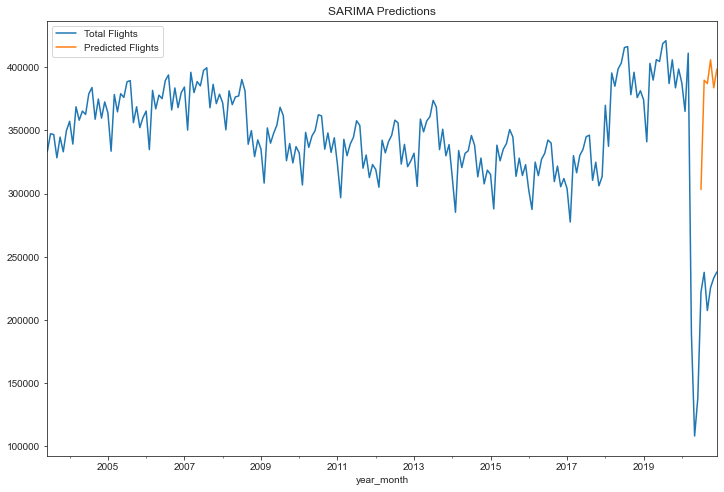

In [90]:
df_forecast.arr_flights.plot(label="Total Flights")
preds_sarima.plot(label="Predicted Flights")
plt.title("SARIMA Predictions")

plt.legend();

In [91]:
preds_sarima

2020-07-01    303305.229543
2020-08-01    389746.334508
2020-09-01    387146.000000
2020-10-01    405926.000000
2020-11-01    383760.000000
2020-12-01    398658.000000
Freq: MS, Name: predicted_mean, dtype: float64

In [92]:
model_sarima = SARIMAX(df_forecast.arr_flights, order=(1,1,0),seasonal_order=(1, 0, 1, 12) ).fit(disp=False)
forecast_sarima = model_sarima.predict(start=len(df_forecast), end=len(df_forecast)+ len(test) + 6)

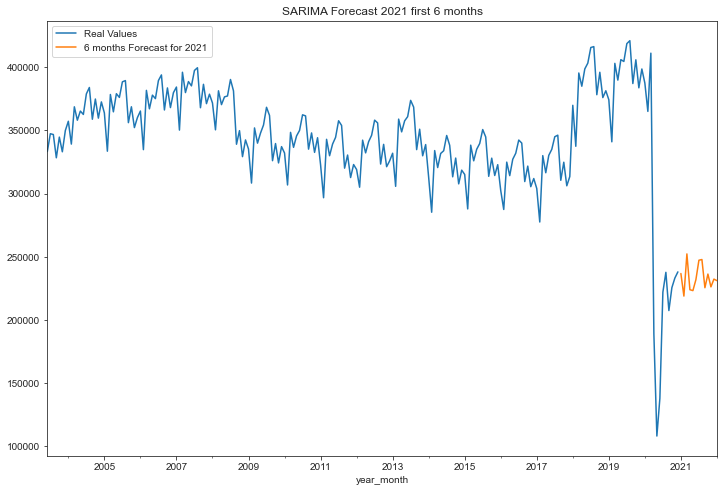

In [93]:
#model.predict(start=1, end=len(df_grouped_wc)).plot(label="Predicted Train")
df_grouped_wc.arr_flights.plot(label="Real Values")
forecast_sarima.plot(label="6 months Forecast for 2021")
plt.title("SARIMA Forecast 2021 first 6 months")
plt.legend();

In [94]:
results_df = results_df.append(pd.DataFrame([["SARIMA",
                                              np.sqrt(mean_squared_error(valid.arr_flights, preds_sarima)),                                              
                                              mean_absolute_error(valid.arr_flights, preds_sarima),
                                             SMAPE(valid.arr_flights, preds_sarima)
                                             ]],
                                            columns=results_df.columns)) 

In [95]:
results_df

,MODEL,RMSE,MAE,SMAPE
0,ExpSmooth,129148.910669,127367.928640,78.758632
0,SARIMA,154309.721362,150683.260675,49.340860


## SARIMAX - Covid period included

In [96]:
list(train.columns)

['arr_flights',
 'lf_part_rate',
 'unemp_rate',
 'emp_air',
 'recession_prob',
 'close_avg']

log transformation to normalize

In [97]:
exog_cols = [
    'lf_part_rate', #labor force participation rate
    #'emp_air',
    #'close_avg', 
    #"unemp_rate",
    #"recession_prob"
    ]

exog_train = train_log[exog_cols]
exog_valid = valid_log[exog_cols]
exog_test= test_log[exog_cols]

In [98]:
train_log = np.log(train)

In [99]:
auto_arima(train.arr_flights, seasonal=True, m=12,stationary=False, maxiter=100,exogenous=exog_train).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:                        y   No. Observations:                  205
Model:             SARIMAX(1, 1, 0, 12)   Log Likelihood               -2277.774
Date:                  Thu, 14 Jul 2022   AIC                           4563.548
Time:                          04:59:25   BIC                           4576.599
Sample:                      06-01-2003   HQIC                          4568.833
                           - 06-01-2020                                         
Covariance Type:                    opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept     8085.7843   2380.138      3.397      0.001    3420.799    1.28e+04
lf_part_rate  2.625e+06     39.475   6.65e+04      0.000    2.62e+06    2.62e+06
ar.S.L12        -0.0016      0.002     -0.865      0.387      -0.005       0.002
sigma2        1.061e+09      0.102   1.04e+10      0.000    1.06e+09    1.06e+09
===================================================================================
Ljung-Box (L1) (Q):                 109.47   Jarque-Bera (JB):              2865.08
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               6.78   Skew:                            -2.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        21.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.27e+24. Standard errors may be unstable.
"""

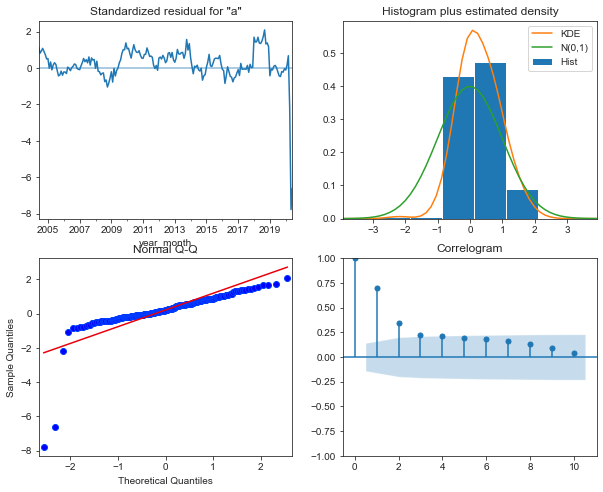

In [100]:
model_sarimax = SARIMAX(endog=train_log.arr_flights,exog=exog_train, order=(0,0,0),seasonal_order=(0,1, 0, 12),exogenous=exog_train, enforce_invertibility=False).fit(disp=False)
model_sarimax.plot_diagnostics(figsize=(10,8));

In [101]:
preds_sarimax = model_sarimax.predict(start=len(train), end=len(train)+len(valid)-1, exog=exog_valid)

print(f"MAE-SARIMA: {mean_absolute_error(valid.arr_flights, preds_sarimax):2f}")
print(f"RMSE-SARIMA: {np.sqrt(mean_squared_error(valid.arr_flights, preds_sarimax)):2f}")
print(f"SMAPE-SARIMA : {SMAPE(valid.arr_flights, preds_sarimax):4f}")
print(f"AIC : {model_sarimax.aic:4f}")

MAE-SARIMA: 227394.366145
RMSE-SARIMA: 227644.605810
SMAPE-SARIMA : 199.977730
AIC : -250.297659


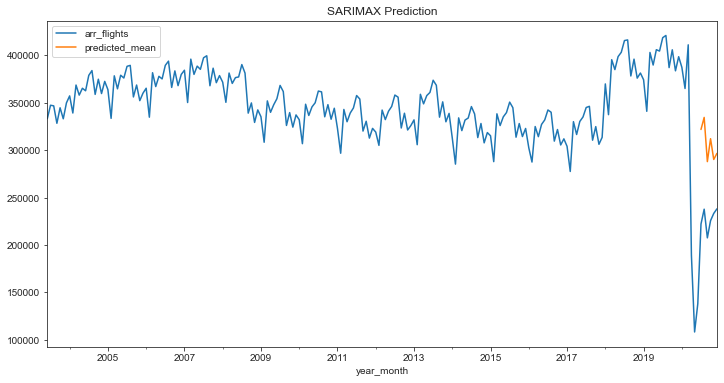

In [102]:
#model.predict(start=1, end=len(train), exog=exog_train).plot()
plt.figure(figsize=(12,6))
df_forecast.arr_flights.plot()
np.exp(preds_sarimax).plot()
plt.title("SARIMAX Prediction")
plt.legend();

In [103]:
model = SARIMAX( np.log(df_forecast.arr_flights), order=(2,0,1),seasonal_order=(1, 0, [1,2], 12), exog=np.log(df_forecast[exog_cols]) , enforce_invertibility=False ).fit(disp=False)
forecast_sarimax = model.predict(start=len(df_forecast), end=len(df_forecast)+ len(test)-1, exog=exog_test)

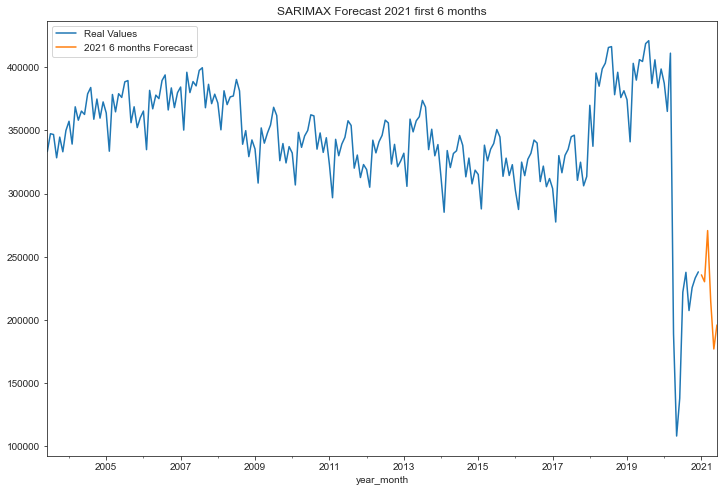

In [104]:
#model.predict(start=1, end=len(df_grouped_wc)).plot(label="Predicted Train")
df_grouped_wc.arr_flights.plot(label="Real Values")
np.exp(forecast_sarimax).plot(label="2021 6 months Forecast")
plt.title("SARIMAX Forecast 2021 first 6 months")
plt.legend();

In [105]:
results_df = results_df.append(pd.DataFrame([["SARIMAX",
                                              np.sqrt(mean_squared_error(valid.arr_flights, preds_sarimax)),                                              
                                              mean_absolute_error(valid.arr_flights, preds_sarimax),

                                             SMAPE(valid.arr_flights, preds_sarimax)
                                             ]],
                                            columns=results_df.columns)) 

In [106]:
results_df

,MODEL,RMSE,MAE,SMAPE
0,ExpSmooth,129148.910669,127367.928640,78.758632
0,SARIMA,154309.721362,150683.260675,49.340860
0,SARIMAX,227644.605810,227394.366145,199.977730


## Hybrid ML Model

In [107]:
def seasonal_features(data):
    
    data["month"] = data.index.month
    
    for k in [1,2,]:
        data[f'sin{k}'] = np.sin(data.index.dayofyear / 365 * 2 * math.pi * k)
        data[f'cos{k}'] = np.cos(data.index.dayofyear  / 365 * 2 * math.pi * k)
        data[f'month_sin{k}'] = np.sin(data.index.month  / 12 * 2 * math.pi * k)
        data[f'month_cos{k}'] = np.cos(data.index.month  / 12 * 2 * math.pi * k)
        data[f'quarter_sin{k}'] = np.sin(data.index.quarter / 4 * 2 * math.pi * k)
        data[f'quarter_cos{k}'] = np.cos(data.index.quarter  / 4 * 2 * math.pi * k)

    return data
cols = ['lf_part_rate', "unemp_rate", 'emp_air',  "recession_prob", ]

train = df_forecast.loc[df_forecast.index <= "2020-12-01"]
train = train[cols]
train = seasonal_features(train)

test = macrodata.loc["2021-01-01":"2021-06-01"][cols]
test = seasonal_features(test)

In [108]:
y = df_grouped_wc.arr_flights

X_test = test

X_train, X_valid = train.loc[train.index<"2020-07-01"], train.loc[train.index>="2020-07-01"]
y_train, y_valid = y.loc[y.index<"2020-07-01"], y.loc[y.index>="2020-07-01"]

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns)
X_valid = pd.DataFrame(scaler.transform(X_valid), index=X_valid.index, columns=X_valid.columns)
X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)


In [109]:
#trend model
lr = Ridge(fit_intercept=True)
lr.fit(X_train, y_train)

# Make predictions
trend_fit = pd.Series( lr.predict(X_train), index=X_train.index,  name="trend")
trend_pred = pd.Series( lr.predict(X_valid), index=X_valid.index,  name="trend")
trend_y = pd.concat([trend_fit,trend_pred ], axis=0)
trend_test = pd.Series( lr.predict(X_test), index=X_test.index,  name="trend_test",)

In [110]:
print(f"MAE-Hybrid-Trend: {mean_absolute_error(y_train, trend_fit):2f}")
print(f"RMSE-Hybrid-Trend: {np.sqrt(mean_squared_error(y_train, trend_fit)):2f}")
print(f"SMAPE-Train Hybrid-Trend : {SMAPE(y_train, trend_fit):4f}")
print(f"SMAPE-Valid Hybrid-Trend : {SMAPE(y_valid, trend_pred):4f}")

MAE-Hybrid-Trend: 19641.587037
RMSE-Hybrid-Trend: 26148.591591
SMAPE-Train Hybrid-Trend : 5.989880
SMAPE-Valid Hybrid-Trend : 27.288011


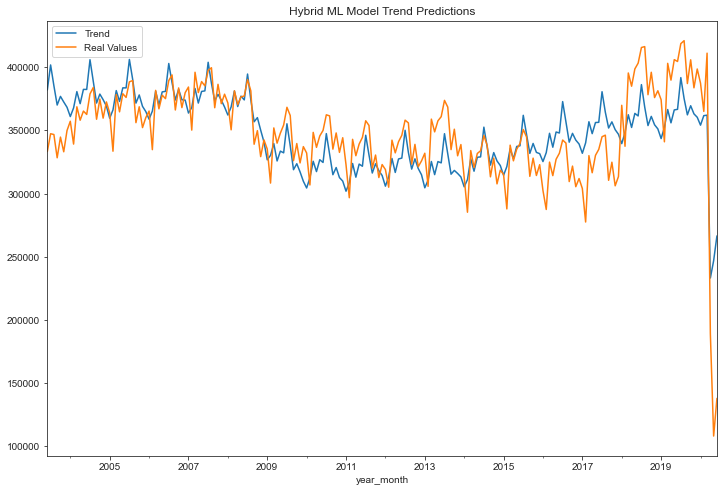

In [111]:
trend_fit.plot(label="Trend")
y_train.plot(label="Real Values")
plt.title("Hybrid ML Model Trend Predictions")
plt.legend();

In [112]:
# Create residuals (the collection of detrended series) from the training set
y_resid_fit = y_train - trend_fit
y_resid_pred = y_valid - trend_pred

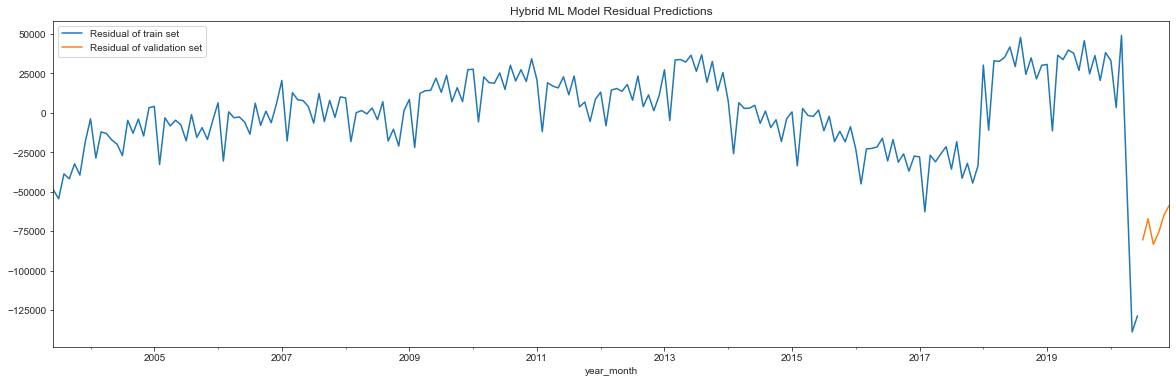

In [113]:
fig, ax = plt.subplots(figsize=(20,6))
y_resid_fit.plot(label="Residual of train set")
y_resid_pred.plot(label="Residual of validation set")
plt.title("Hybrid ML Model Residual Predictions")
plt.legend();

In [114]:
### Train  on the residuals
model = XGBRegressor(objective='reg:squarederror',n_estimators=1000,)
#model = LGBMRegressor(objective='regression', metric="rmse" )
#model=  CatBoostRegressor(loss_function='RMSE', verbose=0)

model.fit(X_train, y_resid_fit,  eval_set = [(X_valid, y_resid_pred)], verbose=0)

# Add the predicted residuals onto the predicted trends
y_fit_boosted = model.predict(X_train) + trend_fit
y_pred_boosted = model.predict(X_valid) + trend_pred

In [115]:
print(f"MAE-Hybrid: {mean_absolute_error(y_valid, y_pred_boosted):2f}")
print(f"RMSE-Hybrid: {np.sqrt(mean_squared_error(y_valid, y_pred_boosted)):2f}")
print(f"SMAPE-Train Hybrid : {SMAPE(y_train, y_fit_boosted):4f}")
print(f"SMAPE-Valid Hybrid : {SMAPE(y_valid, y_pred_boosted):4f}")

MAE-Hybrid: 37202.167145
RMSE-Hybrid: 38672.286783
SMAPE-Train Hybrid : 0.000001
SMAPE-Valid Hybrid : 17.898391


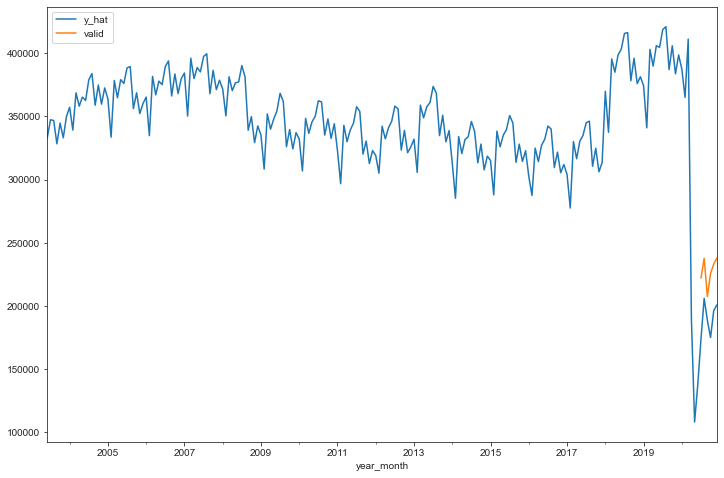

In [116]:
y_fit = pd.concat([y_fit_boosted,y_pred_boosted ], axis=0).rename("y_hat")
y_fit.plot()
y_valid.plot(label="valid")
plt.legend();

In [117]:
trend_y = np.exp(pd.concat([trend_fit, trend_pred], axis=0))
resid_y = pd.concat([y_resid_fit, y_resid_pred], axis=0)

In [118]:

def objective(trial):
    
    params = {
        "verbosity": 0,  # 0 (silent) - 3 (debug)
        "objective": "reg:squarederror",
        "n_estimators": 1000,
        "max_depth": trial.suggest_int("max_depth", 3, 9),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.005, 0.05),
        "colsample_bytree": trial.suggest_loguniform("colsample_bytree", 0.2, 0.9),
        "subsample": trial.suggest_loguniform("subsample", 0.4, 0.9),
        "alpha": trial.suggest_loguniform("alpha", 0.01, 10.0),
        "lambda": trial.suggest_loguniform("lambda", 1e-8, 10.0),
        "gamma": trial.suggest_loguniform("lambda", 1e-8, 10.0),
        #"min_child_weight": trial.suggest_loguniform("min_child_weight", 10, 1000),

    }
    
    model = XGBRegressor(**params)
    model.fit(X_train, y_resid_fit,  eval_set = [(X_valid, y_resid_pred)],  early_stopping_rounds=25, verbose=0)

    # validation prediction
    pred = model.predict(X_valid)
    score = mean_squared_error(y_valid, pred, squared=False)

    return score

In [119]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=500
             # ,timeout=7*60*60
              )

[I 2022-07-14 04:59:43,362] A new study created in memory with name: no-name-0acc4b1d-5047-43a9-b5f4-3da272b5294d
[I 2022-07-14 04:59:44,035] Trial 0 finished with value: 230729.7807129895 and parameters: {'max_depth': 7, 'learning_rate': 0.005663267466896214, 'colsample_bytree': 0.20856222470355518, 'subsample': 0.6475984407420144, 'alpha': 8.127015011945277, 'lambda': 9.402857134075886}. Best is trial 0 with value: 230729.7807129895.
[I 2022-07-14 04:59:44,801] Trial 1 finished with value: 276909.9277890346 and parameters: {'max_depth': 3, 'learning_rate': 0.035456849928228326, 'colsample_bytree': 0.2879862499795139, 'subsample': 0.5236434303080763, 'alpha': 2.0412945897083543, 'lambda': 1.5931717015720515}. Best is trial 0 with value: 230729.7807129895.
[I 2022-07-14 04:59:45,008] Trial 2 finished with value: 285351.8635952618 and parameters: {'max_depth': 3, 'learning_rate': 0.012925711693565418, 'colsample_bytree': 0.7560654576098613, 'subsample': 0.5977237862107472, 'alpha': 0.03

In [120]:
print('Number of finished trials:', len(study.trials))
print('Best trial: score {}, params {}'.format(study.best_trial.value, study.best_trial.params))

Number of finished trials: 500
Best trial: score 228165.50026531384, params {'max_depth': 3, 'learning_rate': 0.005919959239706592, 'colsample_bytree': 0.2624808887307462, 'subsample': 0.7363521444323339, 'alpha': 0.013928267105910967, 'lambda': 9.485221380812362}


In [138]:
params = {
    "verbosity": 0,
    "objective": "reg:squarederror",
    "n_estimators": 1000,
'max_depth': 3, 
'learning_rate': 0.005919959239706592,
'colsample_bytree': 0.2624808887307462, 
'subsample': 0.7363521444323339, 
'alpha': 0.013928267105910967, 
'lambda': 9.485221380812362
}

In [139]:
model = XGBRegressor(**params)
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)],
          early_stopping_rounds=25, verbose=False)

pred_train = model.predict(X_train)
pred_valid = model.predict(X_valid)

print("Train SMAPE", SMAPE(y_train,pred_train))
print("Valid SMAPE", SMAPE(y_valid, pred_valid))


Train SMAPE -6.255246146874716
Valid SMAPE 93.90430925569034


<BarContainer object of 17 artists>

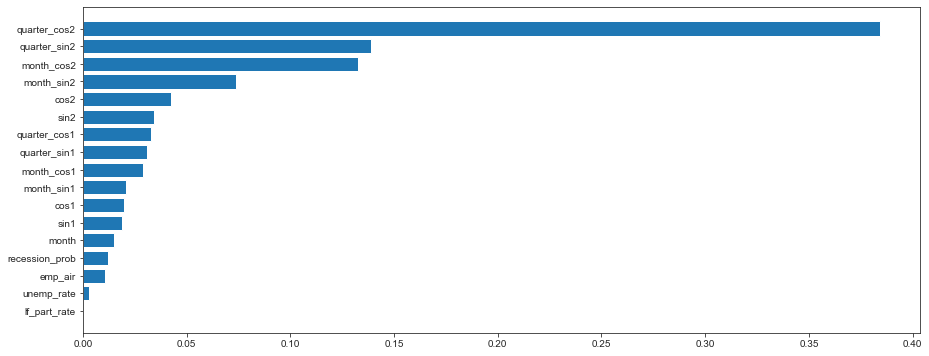

In [140]:
plt.figure(figsize=(15,6))
plt.barh(X_train.columns,np.sort(model.feature_importances_))

In [141]:

tscv = TimeSeriesSplit(5)

preds_test = []
scores = []
oof_pred = {}
pred_train = {}

X = train.loc[train.index <= "2020-07-01"]

for fold, (train_idx, valid_idx) in enumerate(tscv.split(X)):
    
    X_train, y_train = X.iloc[train_idx], resid_y.iloc[train_idx]
    X_valid, y_valid = X.iloc[valid_idx], resid_y.iloc[valid_idx]
    
    model = XGBRegressor(**params)
    model.fit( X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], early_stopping_rounds=25, verbose=0) 
    
    preds_valid = model.predict(X_valid)
    oof_pred.update(dict(zip(valid_idx, preds_valid)))
    
    preds_train = model.predict(X_train)
    pred_train.update(dict(zip(train_idx, preds_train)))
    
    score = SMAPE(y_valid, preds_valid)
    scores.append(score)
    
    print(f"Fold: {fold + 1} Score: {score}")
    print('--'*30)
    
    preds = model.predict(X_test)
    preds_test.append(preds)
    

print(f"\nOverall Validation Score: {np.mean(scores)}")

Fold: 1 Score: 35.294117647058826
------------------------------------------------------------
Fold: 2 Score: 164.67239556833908
------------------------------------------------------------
Fold: 3 Score: 51.820516142381074
------------------------------------------------------------
Fold: 4 Score: -182.15044994641275
------------------------------------------------------------
Fold: 5 Score: 93.90430925569034
------------------------------------------------------------

Overall Validation Score: 32.70817773341132


In [142]:
pred = np.median(preds_test, axis=0)
trend_test = pd.Series( lr.predict(X_test), index=X_test.index,  name="trend_test",)

test_preds = pd.concat([pd.DataFrame(pred, index=X_test.index, columns=["resid"]), trend_test], axis=1)
test_preds["y_hat"] = test_preds.resid + test_preds.trend_test

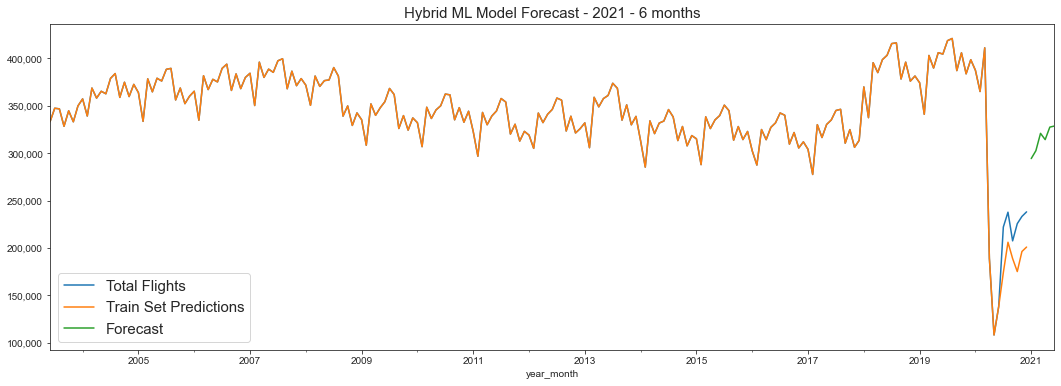

In [143]:
plt.figure(figsize=(18,6))
y_fit = pd.concat([y_fit_boosted,y_pred_boosted ], axis=0).rename("y_hat")
df_grouped_wc.arr_flights.plot(label="Total Flights")
y_fit.plot(label="Train Set Predictions")

test_preds.y_hat.plot(label="Forecast")

plt.legend(fontsize=15)
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
plt.title("Hybrid ML Model Forecast - 2021 - 6 months", fontsize=15);

In [144]:
results_df = results_df.append(pd.DataFrame([["Hybrid ML",
                                              np.sqrt(mean_squared_error(y_valid, pred_valid)),                                              
                                              mean_absolute_error(y_valid, pred_valid),

                                             SMAPE(y_valid, pred_valid)
                                             ]],
                                            columns=results_df.columns)) 

In [145]:
results_df

,MODEL,RMSE,MAE,SMAPE
0,ExpSmooth,129148.910669,127367.928640,78.758632
0,SARIMA,154309.721362,150683.260675,49.340860
0,SARIMAX,227644.605810,227394.366145,199.977730
0,Hybrid ML,47768.119978,39479.134193,93.961796
0,Hybrid ML,47764.052421,39474.163696,93.904309


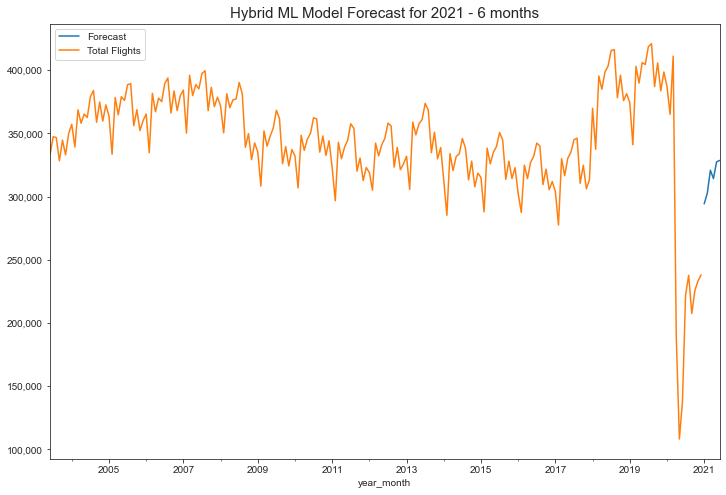

In [146]:
test_preds.y_hat.plot(label="Forecast")
df_forecast.arr_flights.plot(label="Total Flights")


plt.legend()
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
plt.title("Hybrid ML Model Forecast for 2021 - 6 months", fontsize=15);

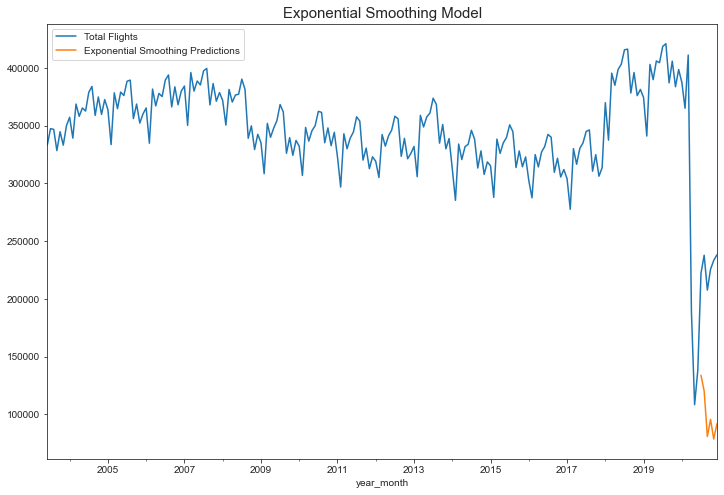

In [147]:
preds_exp = model_exp.forecast(6)  

df_forecast.arr_flights.plot(label="Total Flights")
preds_exp.plot(label="Exponential Smoothing Predictions")
plt.legend()
plt.title("Exponential Smoothing Model", fontsize=15);

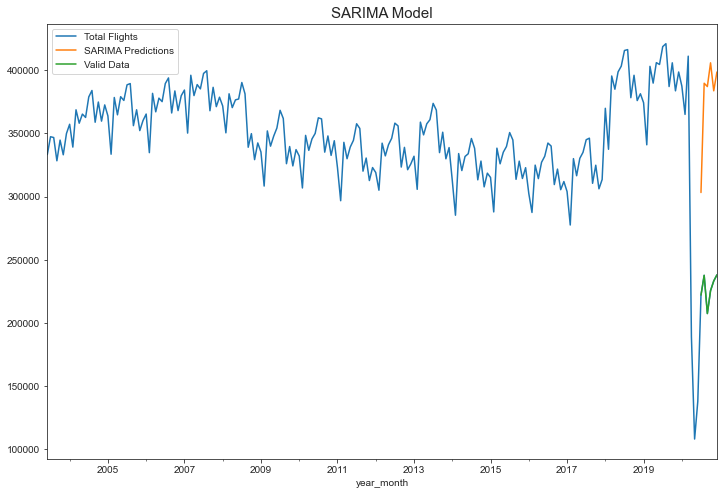

In [148]:
df_forecast.arr_flights.plot(label="Total Flights")
preds_sarima.plot(label="SARIMA Predictions")
valid.arr_flights.plot(label="Valid Data")
plt.title("SARIMA Model", fontsize=15);
plt.legend();

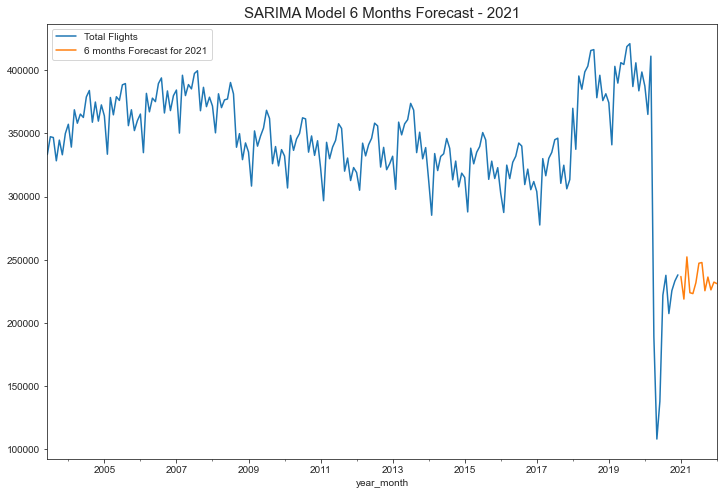

In [149]:
#model.predict(start=1, end=len(df_grouped_wc)).plot(label="Predicted Train")
df_grouped_wc.arr_flights.plot(label="Total Flights")
forecast_sarima.plot(label="6 months Forecast for 2021")
plt.title("SARIMA Model 6 Months Forecast - 2021", fontsize=15);
plt.legend();

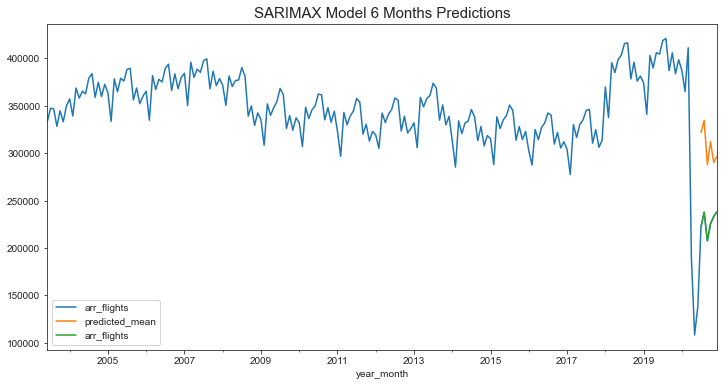

In [150]:
#model.predict(start=1, end=len(train), exog=exog_train).plot()
plt.figure(figsize=(12,6))
y.plot()
np.exp(preds_sarimax).plot()
valid.arr_flights.plot()
plt.title("SARIMAX Model 6 Months Predictions", fontsize=15)
plt.legend();

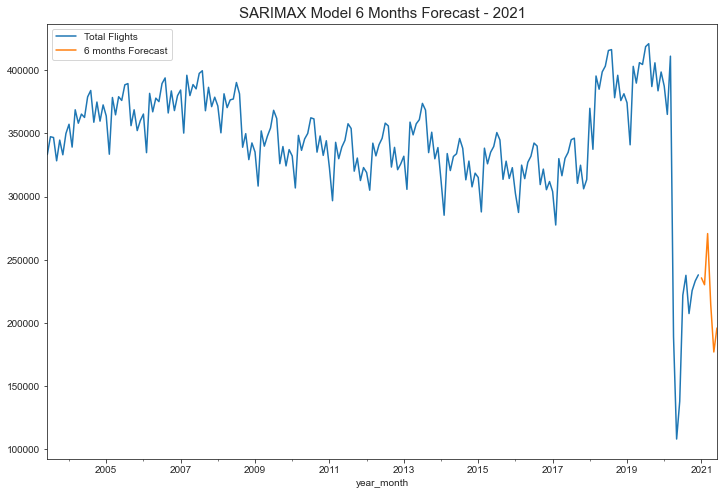

In [151]:
#model.predict(start=1, end=len(df_grouped_wc)).plot(label="Predicted Train")
df_grouped_wc.arr_flights.plot(label="Total Flights")
np.exp(forecast_sarimax).plot(label="6 months Forecast")
plt.title("SARIMAX Model 6 Months Forecast - 2021", fontsize=15)
plt.legend();

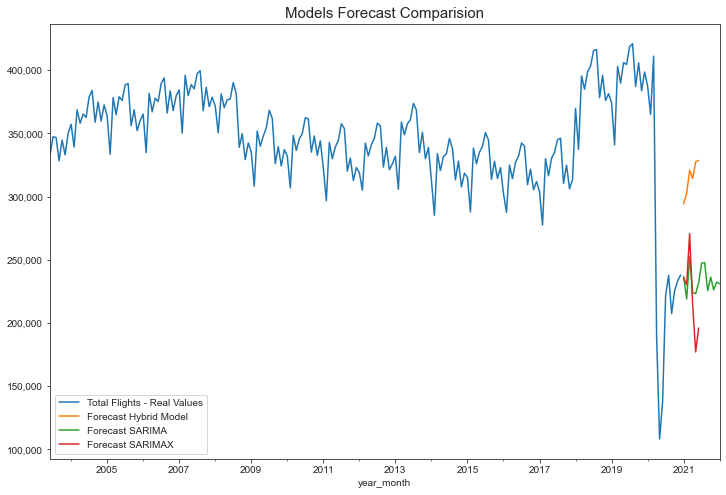

In [154]:
df_forecast.arr_flights.plot(label="Total Flights - Real Values")
test_preds.y_hat.plot(label="Forecast Hybrid Model")
forecast_sarima.plot(label="Forecast SARIMA")
np.exp(forecast_sarimax).plot(label="Forecast SARIMAX")

plt.legend()
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
plt.title("Models Forecast Comparision", fontsize=15);

# Summary

It is important to to forecast total flights recovery after COVID-19 pandemic. This lead the airlines to plan the the next months and revise their plan monthly. This will also helps airlines not to loose the opportunities.

SARIMAX and and Hybrid model setup based on the macroeconomic features (Labor force participation rate, unemployment rate, employment in aviation sector and probability of economic recession). Sharp decrease in the total flights in US during COVID-19 pandemic makes difficult to capture this period pattern. However, SARIMAX and Hybrid models are not better than SARIMA model. 